In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, false_discovery_control

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

import warnings

epis = ['VLDFAPPGA','RMFPNAPYL','NLVPMVATV','GILGFVFTL','GLCTLVAML','YLQPRTFLL','ELAGIGILTV']

## Functions to plot figures

In [2]:
def plot_freqbars_all(d_cohorts,cohorts,mods,title="",figpath="",percent=False,ntopclones=-1,
                      w=9.2,h=5,dpi=350,show=True,d_repsize=None,xmax=None,format_pct=False):
    with sns.axes_style("whitegrid",{'patch.force_edgecolor': True,'patch.edgecolor': '#00000080'}):
        cbcols = ['#00CC95','#4D51C8','#FAF7C3','#F0B7B0','#B8CCE1','#A36B75','#B29E62']
        height_ratios=[len(d_cohorts[cohort]) for cohort in cohorts]
        
        fig, axs = plt.subplots(nrows=len(cohorts),ncols=1,sharex=True,figsize=(w,h),dpi=dpi,height_ratios=height_ratios)
        sns.set_context(rc = {'patch.linewidth': 0.05})

        for i,cohort in enumerate(cohorts):
            d_pts = d_cohorts[cohort]
            ax = axs[i]
            pts = list(d_pts.keys())
            
            for p in pts:
                cols_all = []
                d_freqs=d_pts[p]
                d_freqs
                tot_freq = sum([sum(d_freqs[m]) for m in mods])

                for i, mod in enumerate(mods):
                    widths = d_freqs[mod]
                    if percent:
                        widths=widths/tot_freq
                    if len(widths)==0:
                        continue
                    # Only top clones
                    if ntopclones >=0:
                        widths = np.concatenate((widths[0:ntopclones],np.array([sum(widths[ntopclones:])])))

                    starts = np.cumsum(widths) - widths
                    if i==0:
                        starts_all = starts
                        widths_all = widths
                    else:
                        starts_all = np.concatenate((starts_all, starts+np.sum(widths_all)))
                        widths_all = np.concatenate((widths_all, widths))
                    c= [cbcols[i]]
                    cols_all = cols_all + c*len(widths)
                lab = str(p)
                if d_repsize!=None:
                    lab = lab+" ("+str(d_repsize[cohort][p])+")"
                rects = ax.barh(lab,width=widths_all, left=starts_all, height=0.8, color=cols_all,alpha=1)
            ax.set_axisbelow(True)
            ax.set_ylim([-.75,len(pts)-.25])
            ax.invert_yaxis()
            ax.xaxis.set_tick_params(which='both', labelbottom=True)
            ax.set_title(cohort+" "+title,loc="left",fontdict={'fontsize':10})
            plt.xlabel("Frequency")
            ax.grid(axis="x",linewidth=0.2,color="#040404")
            ax.grid(False,axis="y")
            
            if xmax!=None:
                plt.xlim(right=xmax)
        if format_pct:
            vals = ax.get_xticks()
            ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
        if figpath!="":
            plt.tight_layout()
            plt.savefig(figpath)
        if show:
            plt.show()

def plot_scTCRfreq_hla(df, cohort, hla_col, palette,hue_order,figfilename="",leg=True):
    df = df.loc[df["Cohort"].values==cohort,:]
    with sns.axes_style("whitegrid",{'patch.force_edgecolor': True,'patch.edgecolor': "#D7654F"}):
        fig, ( ax2) = plt.subplots(1, 1, sharex=True,figsize=(5.5,6),dpi=350)

        plt.sca(ax2)
        sns.boxplot(df,x="Epitope",y="Freq",palette=["#020202"],fliersize=0,linewidth=.8,fill=False)
        sns.swarmplot(df,x="Epitope",y="Freq",hue=hla_col,palette=palette,size=5,legend=leg,hue_order=hue_order,edgecolor="k",alpha=0.8,linewidth=0)
        plt.ylabel("{:>30s}".format("Frequency of epitope-specific TCRs"))

        ax2.set_ylim(-0.002, 0.14)
        ax2.set_frame_on(True)

        ax2.set_xticks([0,1,2,3,4,5,6])
        ax2.set_xticklabels(["WT1\nVLDFAPPGA","WT1\nRMFPNAPYL","CMV\nNLVPMVATV",
                            "IAV\nGILGFVFTL","EBV\nGLCTLVAML","SARS-CoV-2\nYLQPRTFLL",
                            "melanoma\nELAGIGILTV"],rotation=45)

        plt.xlim([-0.5,6.5])
        vals = ax2.get_yticks()
        warnings.filterwarnings("ignore")
        ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
        plt.tight_layout()
        if figfilename!="":
            plt.savefig(figfilename)
        plt.show()

# TCR frequencies and repertoire sizes

## Read in preprocessed data

In [3]:
# Dictionary that contains the frequency of each epitope-specific TCR in each cohort
d_cohorts = np.load("data/dict_epitope-specific_TCR_freqs.npy",allow_pickle=True).item()
d_sizes = np.load("data/dict_cohort_sizes.npy",allow_pickle=True).item()

df_cohorts_tot   = pd.read_csv("data/TCR_predicted_total_epitope-specific_TCR_freqs.csv",keep_default_na=False, na_values=['_'])

In [4]:
df_cohorts_tot

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
0     0.009843   0.011923   0.007764   0.005407   0.017053   0.009705   
1     0.008225   0.007025   0.008475   0.005650   0.012100   0.002850   
2     0.049875   0.005050   0.003700   0.005875   0.005550   0.006525   
3     0.014615   0.010842   0.005827   0.005683   0.010077   0.006448   
4     0.007817   0.003908   0.010585   0.003148   0.007980   0.002008   
..         ...        ...        ...        ...        ...        ...   
120   0.010100   0.008150   0.004900   0.007525   0.007025   0.004650   
121   0.017900   0.010025   0.003750   0.008425   0.009475   0.004050   
122   0.027650   0.008700   0.005050   0.007500   0.006575   0.003800   
123   0.007025   0.006475   0.005425   0.007175   0.007125   0.005000   
124   0.018575   0.008075   0.004575   0.008200   0.007825   0.003375   

     ELAGIGILTV        ID  Cohort   A2  
0      0.009705  CML-PB-1  CML-PB   NA  
1      0.007300  CML-PB-2  CML-PB   NA  
2      0.003625  CML-PB-3  CML-PB   NA  
3      0.022495  CML-PB-4  CML-PB   NA  
4      0.006514  CML-PB-5  CML-PB   NA  
..          ...       ...     ...  ...  
120    0.004875  HC-PB-36   HC-PB  yes  
121    0.007200  HC-PB-37   HC-PB  yes  
122    0.005000  HC-PB-38   HC-PB   no  
123    0.005950  HC-PB-39   HC-PB  yes  
124    0.005000  HC-PB-40   HC-PB  yes  

[125 rows x 10 columns]

In [5]:
df_cohorts_long = df_cohorts_tot.melt(id_vars=["Cohort","ID","A2"],value_name="Freq",var_name="Epitope")

In [6]:
cohorts_bulk = ["AML-BM","MDS-BM","CML-BM","CML-PB","HC-PB"]
cohorts_sc   = ["AML-BM-SC","CML-PB-SC"]

In [7]:
df_bulk = df_cohorts_long.loc[[c in cohorts_bulk for c in df_cohorts_long["Cohort"]]]
df_bulk

Cohort        ID   A2     Epitope      Freq
0    CML-PB  CML-PB-1   NA   VLDFAPPGA  0.009843
1    CML-PB  CML-PB-2   NA   VLDFAPPGA  0.008225
2    CML-PB  CML-PB-3   NA   VLDFAPPGA  0.049875
3    CML-PB  CML-PB-4   NA   VLDFAPPGA  0.014615
4    CML-PB  CML-PB-5   NA   VLDFAPPGA  0.007817
..      ...       ...  ...         ...       ...
870   HC-PB  HC-PB-36  yes  ELAGIGILTV  0.004875
871   HC-PB  HC-PB-37  yes  ELAGIGILTV  0.007200
872   HC-PB  HC-PB-38   no  ELAGIGILTV  0.005000
873   HC-PB  HC-PB-39  yes  ELAGIGILTV  0.005950
874   HC-PB  HC-PB-40  yes  ELAGIGILTV  0.005000

[784 rows x 5 columns]

In [8]:
df_sc = df_cohorts_long.loc[[c in cohorts_sc for c in df_cohorts_long["Cohort"]]]

# Add HLA information manually for sc cohorts
df_sc["HLA_epi"] = "NA"
for pid in ["AML-BM-SC-4","AML-BM-SC-5","AML-BM-SC-6","AML-BM-SC-7","CML-PB-SC-4","CML-PB-SC-6"]:
    I = np.logical_and(df_sc["ID"]==pid, df_sc["Epitope"] == "RMFPNAPYL")
    df_sc.loc[I,"HLA_epi"] = "strong"
    
for pid in ["AML-BM-SC-1","AML-BM-SC-2","AML-BM-SC-3","CML-PB-SC-1","CML-PB-SC-2","CML-PB-SC-3","CML-PB-SC-5"]:
    I = np.logical_and(df_sc["ID"]==pid, df_sc["Epitope"].values=="RMFPNAPYL")
    df_sc.loc[I,"HLA_epi"] = "weak"
    
for pid in ["AML-BM-SC-4","AML-BM-SC-5","AML-BM-SC-6","AML-BM-SC-7","CML-PB-SC-4","CML-PB-SC-6"]:
    I = np.logical_and(df_sc["ID"]==pid, df_sc["Epitope"].values=="VLDFAPPGA")
    df_sc.loc[I,"HLA_epi"] = "weak"
    
for pid in ["AML-BM-SC-1","AML-BM-SC-2","AML-BM-SC-3","CML-PB-SC-1","CML-PB-SC-2","CML-PB-SC-3","CML-PB-SC-5"]:
    I = np.logical_and(df_sc["ID"]==pid, df_sc["Epitope"].values=="VLDFAPPGA")
    df_sc.loc[I,"HLA_epi"] = "not"

df_sc["HLA_epi_alt"] = df_sc["HLA_epi"]
for pid in ["AML-BM-SC-4","AML-BM-SC-5","AML-BM-SC-6","AML-BM-SC-7","CML-PB-SC-4","CML-PB-SC-6"]:
    df_sc.loc[df_sc["ID"].values==pid,"HLA_epi_alt"] = "HLA-A02"

df_sc

/var/folders/0m/tgqkpk8500s2c2fc2fs3gdmh2l9yy_/T/ipykernel_46634/3540364006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc["HLA_epi"] = "NA"
/var/folders/0m/tgqkpk8500s2c2fc2fs3gdmh2l9yy_/T/ipykernel_46634/3540364006.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc["HLA_epi_alt"] = df_sc["HLA_epi"]


Cohort           ID   A2     Epitope      Freq HLA_epi HLA_epi_alt
12   CML-PB-SC  CML-PB-SC-1   no   VLDFAPPGA  0.020434     not         not
13   CML-PB-SC  CML-PB-SC-2   no   VLDFAPPGA  0.004164     not         not
14   CML-PB-SC  CML-PB-SC-3   no   VLDFAPPGA  0.008467     not         not
15   CML-PB-SC  CML-PB-SC-4  yes   VLDFAPPGA  0.009423    weak     HLA-A02
16   CML-PB-SC  CML-PB-SC-5   no   VLDFAPPGA  0.025983     not         not
..         ...          ...  ...         ...       ...     ...         ...
770  AML-BM-SC  AML-BM-SC-3   no  ELAGIGILTV  0.002282      NA          NA
771  AML-BM-SC  AML-BM-SC-4  yes  ELAGIGILTV  0.003629      NA     HLA-A02
772  AML-BM-SC  AML-BM-SC-5  yes  ELAGIGILTV  0.001202      NA     HLA-A02
773  AML-BM-SC  AML-BM-SC-6  yes  ELAGIGILTV  0.008782      NA     HLA-A02
774  AML-BM-SC  AML-BM-SC-7  yes  ELAGIGILTV  0.004890      NA     HLA-A02

[91 rows x 7 columns]

## Mann Whitney U-test: greater
Do other cohorts have higher frequency of epitope-specific TCRs compared to healthy (HC-PB)?

In [9]:
d_p, d_s = {}, {}
for epi in ['VLDFAPPGA','RMFPNAPYL','NLVPMVATV','GILGFVFTL','GLCTLVAML','YLQPRTFLL','ELAGIGILTV']:
    d_p[epi], d_s[epi] = {}, {}
    x_h   = list(df_bulk["Freq"][(df_bulk["Epitope"]==epi) & (df_bulk["Cohort"]=="HC-PB")].values)
    for c in ["AML-BM","MDS-BM","CML-BM","CML-PB"]:
        xc = list(df_bulk["Freq"][(df_bulk["Epitope"]==epi) & (df_bulk["Cohort"]==c)].values)
        mwut = mannwhitneyu(xc,x_h,alternative="greater")
        d_p[epi][c]= mwut.pvalue 
        d_s[epi][c]= mwut.statistic  

df_pval_greater = pd.DataFrame(d_p)
df_stat_greater = pd.DataFrame(d_s)

In [10]:
df_pval_greater

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
AML-BM   0.886238   0.068423   0.000049   0.349329   0.005996   0.014129   
MDS-BM   0.839175   0.454375   0.000023   0.355373   0.000034   0.000383   
CML-BM   0.770409   0.056029   0.001582   0.713169   0.016103   0.012205   
CML-PB   0.717538   0.175162   0.001681   0.996691   0.011609   0.050495   

        ELAGIGILTV  
AML-BM    0.001359  
MDS-BM    0.000074  
CML-BM    0.039476  
CML-PB    0.013367

In [11]:
df_stat_greater

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
AML-BM      341.0      518.5      677.0      446.0      586.0      565.0   
MDS-BM      427.0      509.0      803.0      528.0      796.0      750.0   
CML-BM      243.0      361.0      430.0      252.0      389.0      394.5   
CML-PB      214.0      283.5      375.5      115.5      345.0      316.0   

        ELAGIGILTV  
AML-BM       618.0  
MDS-BM       782.0  
CML-BM       369.5  
CML-PB       342.5

# TCR frequency figures

### Colors
* for each epitope
* for each bulk cohort
* For bulk HLA (A2, not A2, NA)

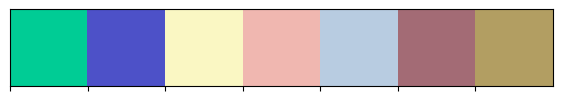

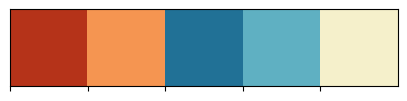

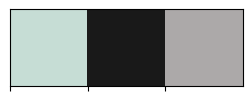

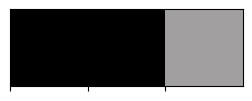

In [12]:
cbcols ="#00CC95 #4D51C8 #FAF7C3 #F0B7B0 #B8CCE1 #A36B75 #B29E62".split(" ")
cohort_cols=["#b53319","#f59551","#217196","#5fb0c2","#f5f0cb"]
sns.palplot(cbcols)
sns.palplot(cohort_cols)

palette_A2 = {"yes": "#C6DDD5",
             "no": "#191919",
             "NA": "#ACA9A9"}
palette_A2_edges = {"yes": "#000000",
                    "no": "#000000",
                    "NA": "#A19F9F"}
sns.palplot(palette_A2.values())
sns.palplot(palette_A2_edges.values())

### Average TCR frequencies in bulk cohorts 
with broken y-axis

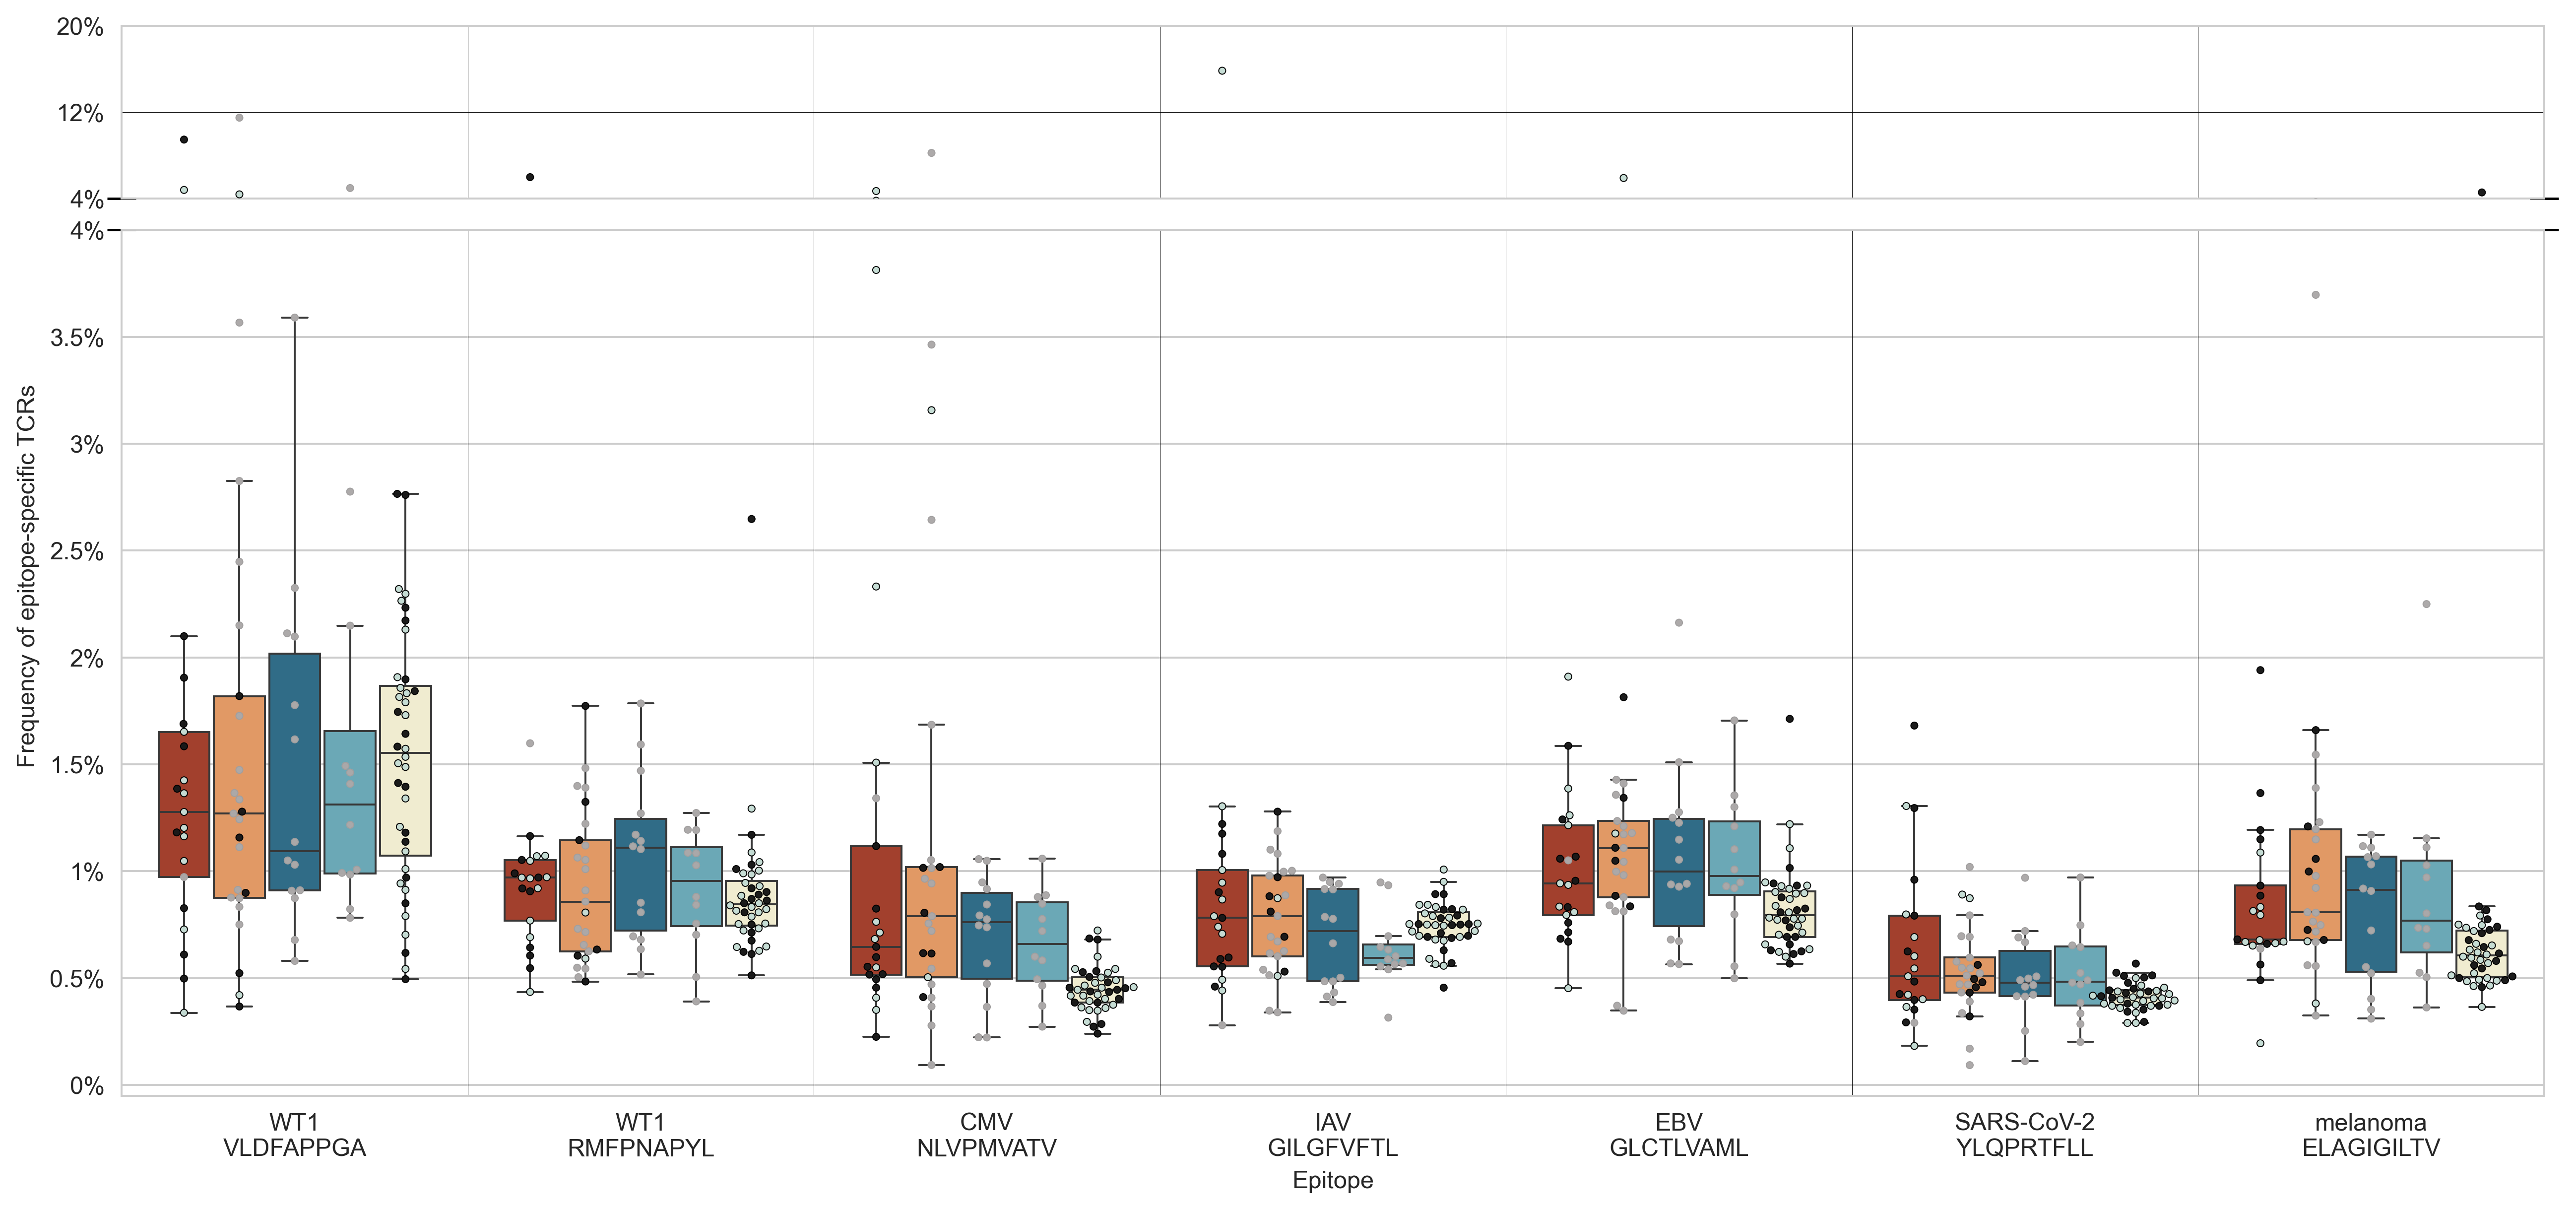

In [13]:
ho = ["AML-BM","MDS-BM","CML-BM","CML-PB","HC-PB"]
swarm_cohorts = ho *7
vs = [.5,1.5,2.5,3.5,4.5,5.5] # vertical lines to be drawn
with sns.axes_style("whitegrid"):
    # Not showing warnings due to each patient being only in 0-4% or 4-20% and not in both
    warnings.filterwarnings("ignore")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(18,8),dpi=350,height_ratios=[1,5])
    fig.subplots_adjust(hspace=0.06)  # adjust space between Axes
    
    # AX 1: outliers only
    plt.sca(ax1)
    swarm = sns.swarmplot(df_bulk,x="Epitope",y="Freq",hue="Cohort",dodge=True,size=2.9,palette="dark:black",
                          alpha=0.99,legend=False,hue_order=ho,linewidth=0.4)
    
    for i, collection in enumerate(swarm.collections):
        cohort = swarm_cohorts[i]  
        subset = df_bulk.loc[np.logical_and(df_bulk["Cohort"]==cohort, df_bulk["Epitope"]=="RMFPNAPYL"),:] 
        facecolors = [palette_A2[h] for h in subset["A2"]]
        edgecolors = [palette_A2_edges[h] for h in subset["A2"]]
        collection.set_facecolors(facecolors)
        collection.set_edgecolors(edgecolors)
    
    plt.grid(axis="y",linewidth=0.2,color="#010101")
    ax1.xaxis.set_minor_locator(MultipleLocator())
    plt.vlines(vs,ymin=0.04,ymax=0.2,linewidth=0.2,color="#010101")
    
    plt.yticks([.04,.12,.2])
    plt.ylabel("")
    
    ax1.set_ylim(0.04, .2)
    ax1.tick_params(labeltop=False)
    ax1.set_frame_on(True)
    
    # AX 2: most of the data
    plt.sca(ax2)
    sns.boxplot(df_bulk,x="Epitope",y="Freq",hue="Cohort",palette=cohort_cols,fliersize=0,gap=0.08,linewidth=.8,hue_order=ho,legend=False)
    swarm2 = sns.swarmplot(df_bulk,x="Epitope",y="Freq",hue="Cohort",dodge=True,size=2.9,palette="dark:black",
                          alpha=0.99,legend=False,hue_order=ho,linewidth=0.4)
            
    for i, collection in enumerate(swarm2.collections):
        cohort = swarm_cohorts[i]  
        subset = df_bulk.loc[np.logical_and(df_bulk["Cohort"]==cohort, df_bulk["Epitope"]=="RMFPNAPYL"),:] 
        facecolors = [palette_A2[h] for h in subset["A2"]]
        edgecolors = [palette_A2_edges[h] for h in subset["A2"]]
        collection.set_facecolors(facecolors)
        collection.set_edgecolors(edgecolors)
    
    plt.vlines(vs,ymin=-0.0005,ymax=0.04,linewidth=0.2,color="#010101")
    plt.ylabel("{:>60s}".format("Frequency of epitope-specific TCRs"))

    ax2.set_ylim(-0.0005, 0.04)
    ax2.set_frame_on(True)
    
    # SPLIT MARKS
    d = 0  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    ax2.set_xticks([0,1,2,3,4,5,6])
    ax2.set_xticklabels(["WT1\nVLDFAPPGA","WT1\nRMFPNAPYL","CMV\nNLVPMVATV",
                        "IAV\nGILGFVFTL","EBV\nGLCTLVAML","SARS-CoV-2\nYLQPRTFLL",
                        "melanoma\nELAGIGILTV"])

    plt.xlim([-0.5,6.5])
    vals = [.04,.12,.2]
    ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    vals = [0,.005,.01,.015,.02,.025,.03,.035,.04]
    ax2.set_yticks(vals)
    ax2.set_yticklabels(['0%','0.5%','1%','1.5%','2%','2.5%','3%','3.5%','4%'])

    plt.show()

### Average TCR frequencies in single-cell cohorts

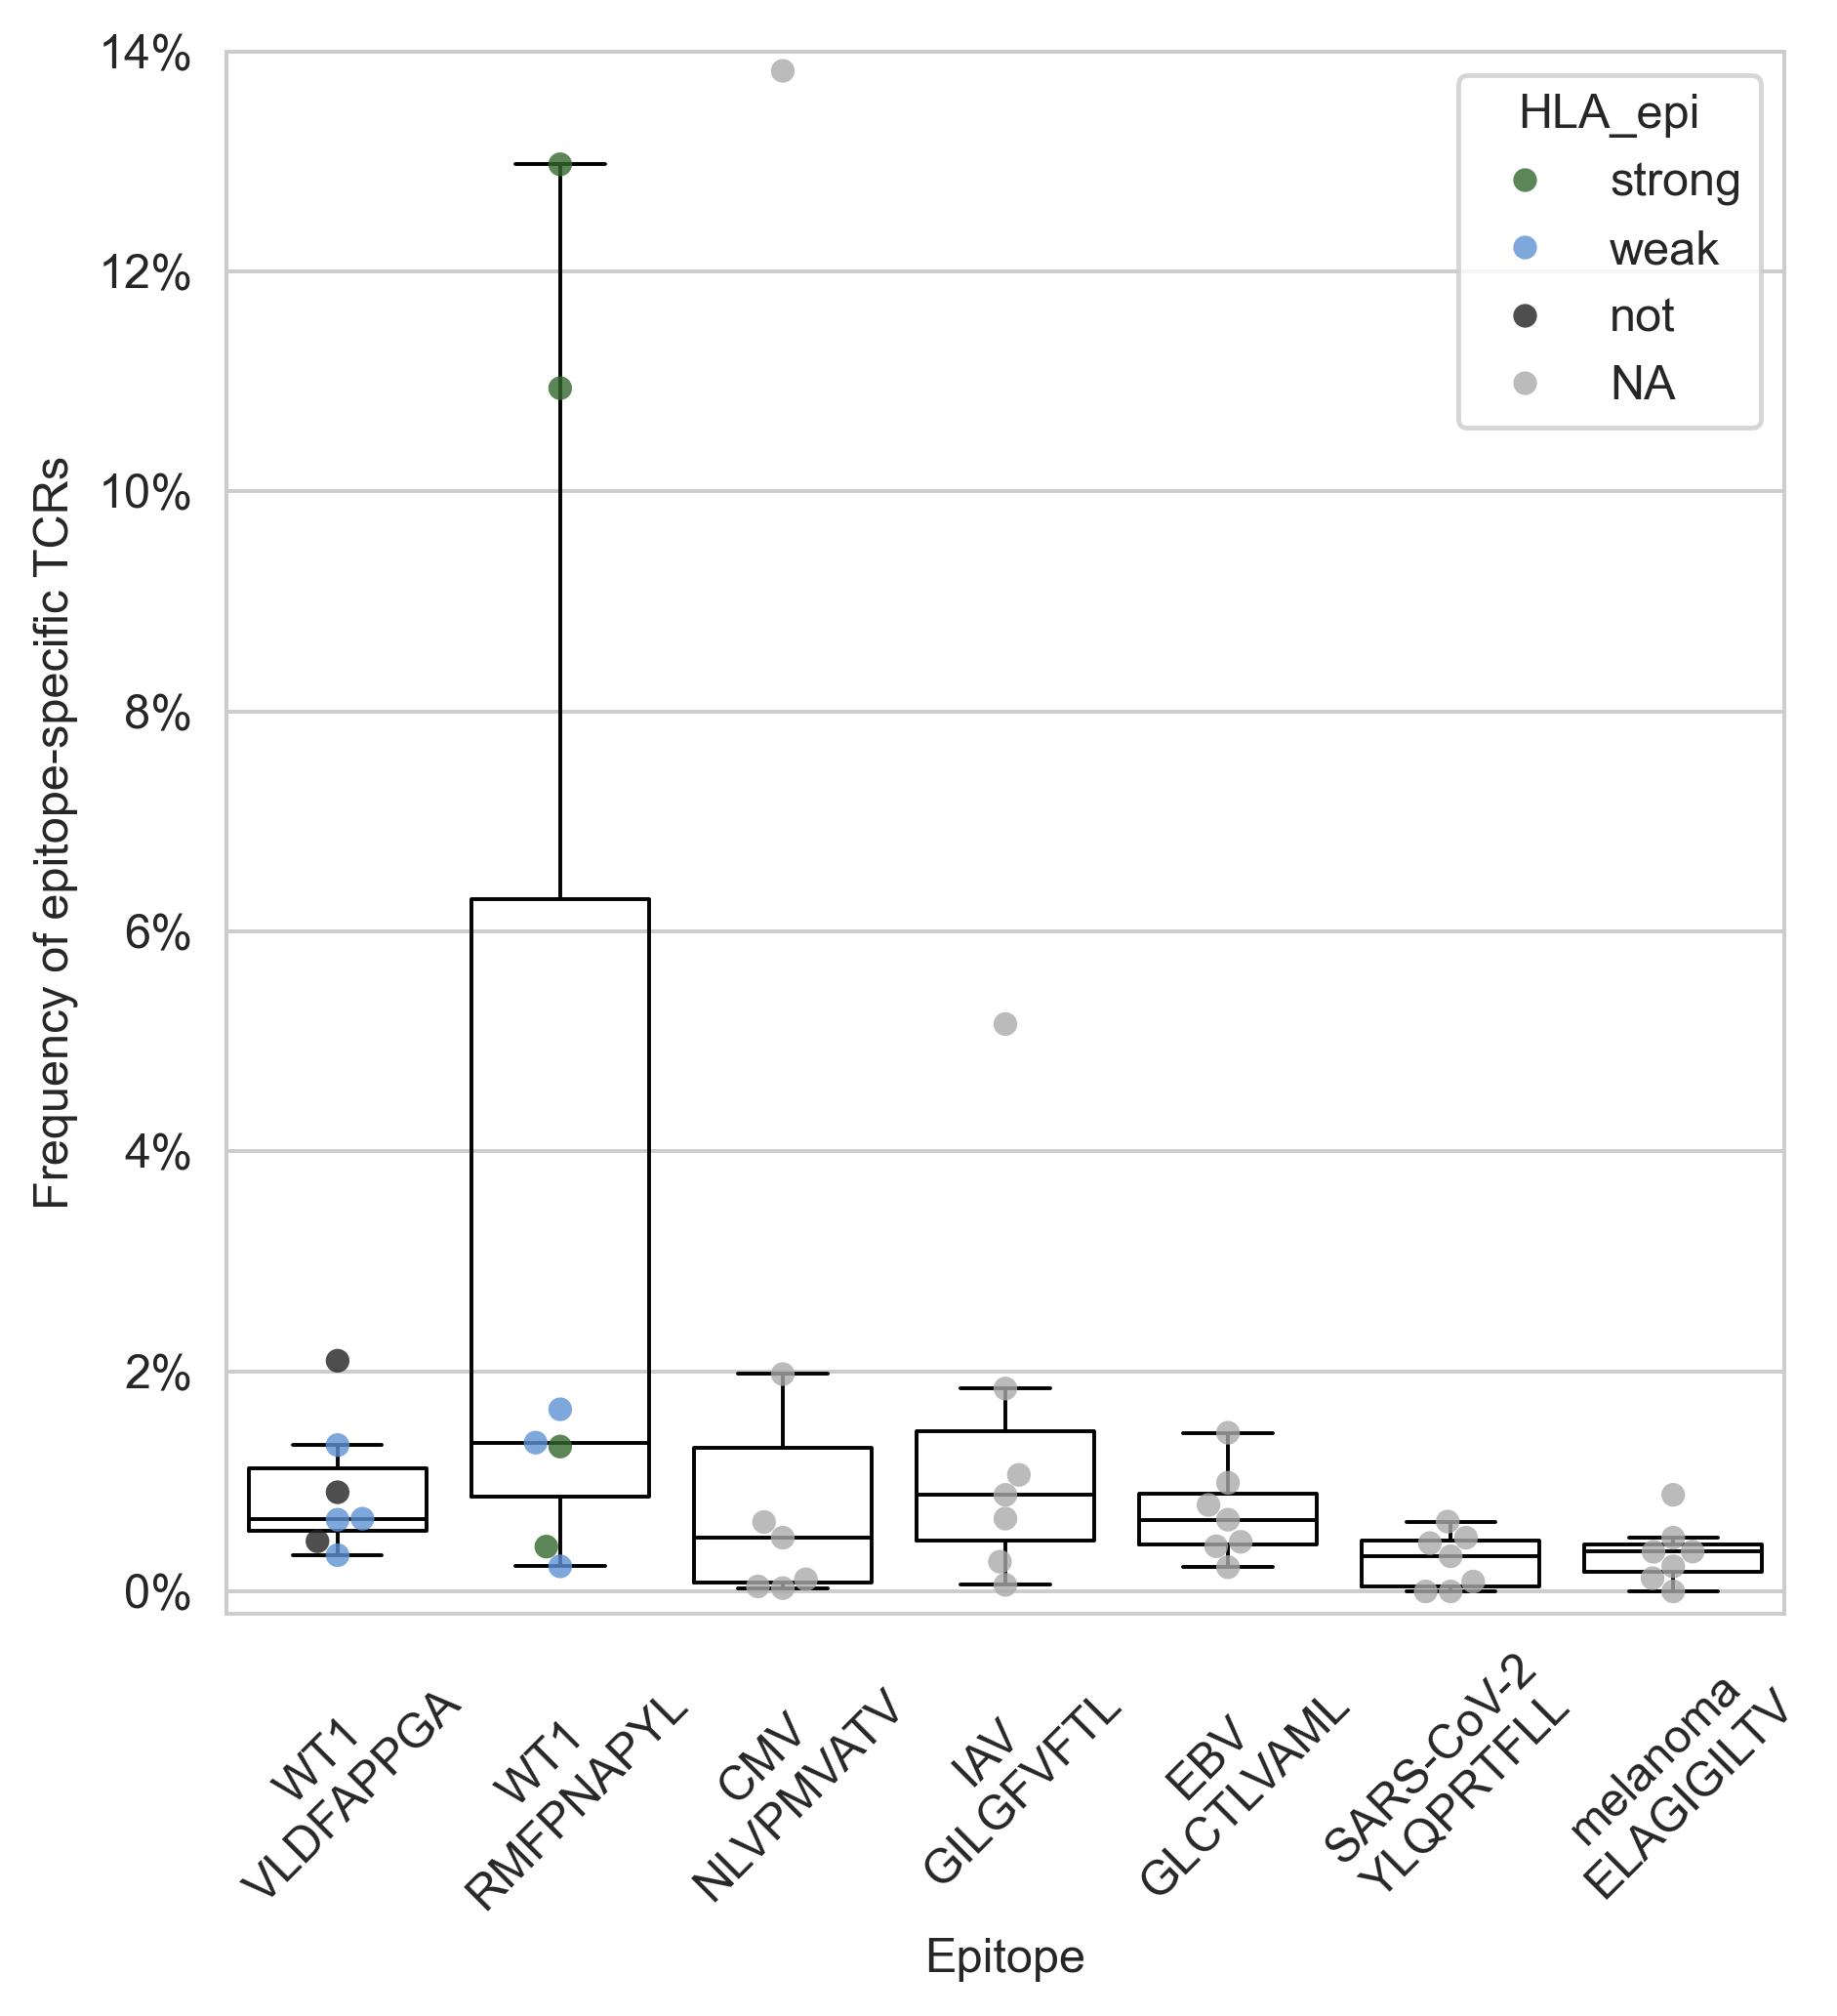

In [14]:
plot_scTCRfreq_hla(df_sc,"AML-BM-SC","HLA_epi",["#34682E","#5E92D4","#222222","#AAAAAA"],["strong","weak","not","NA"])

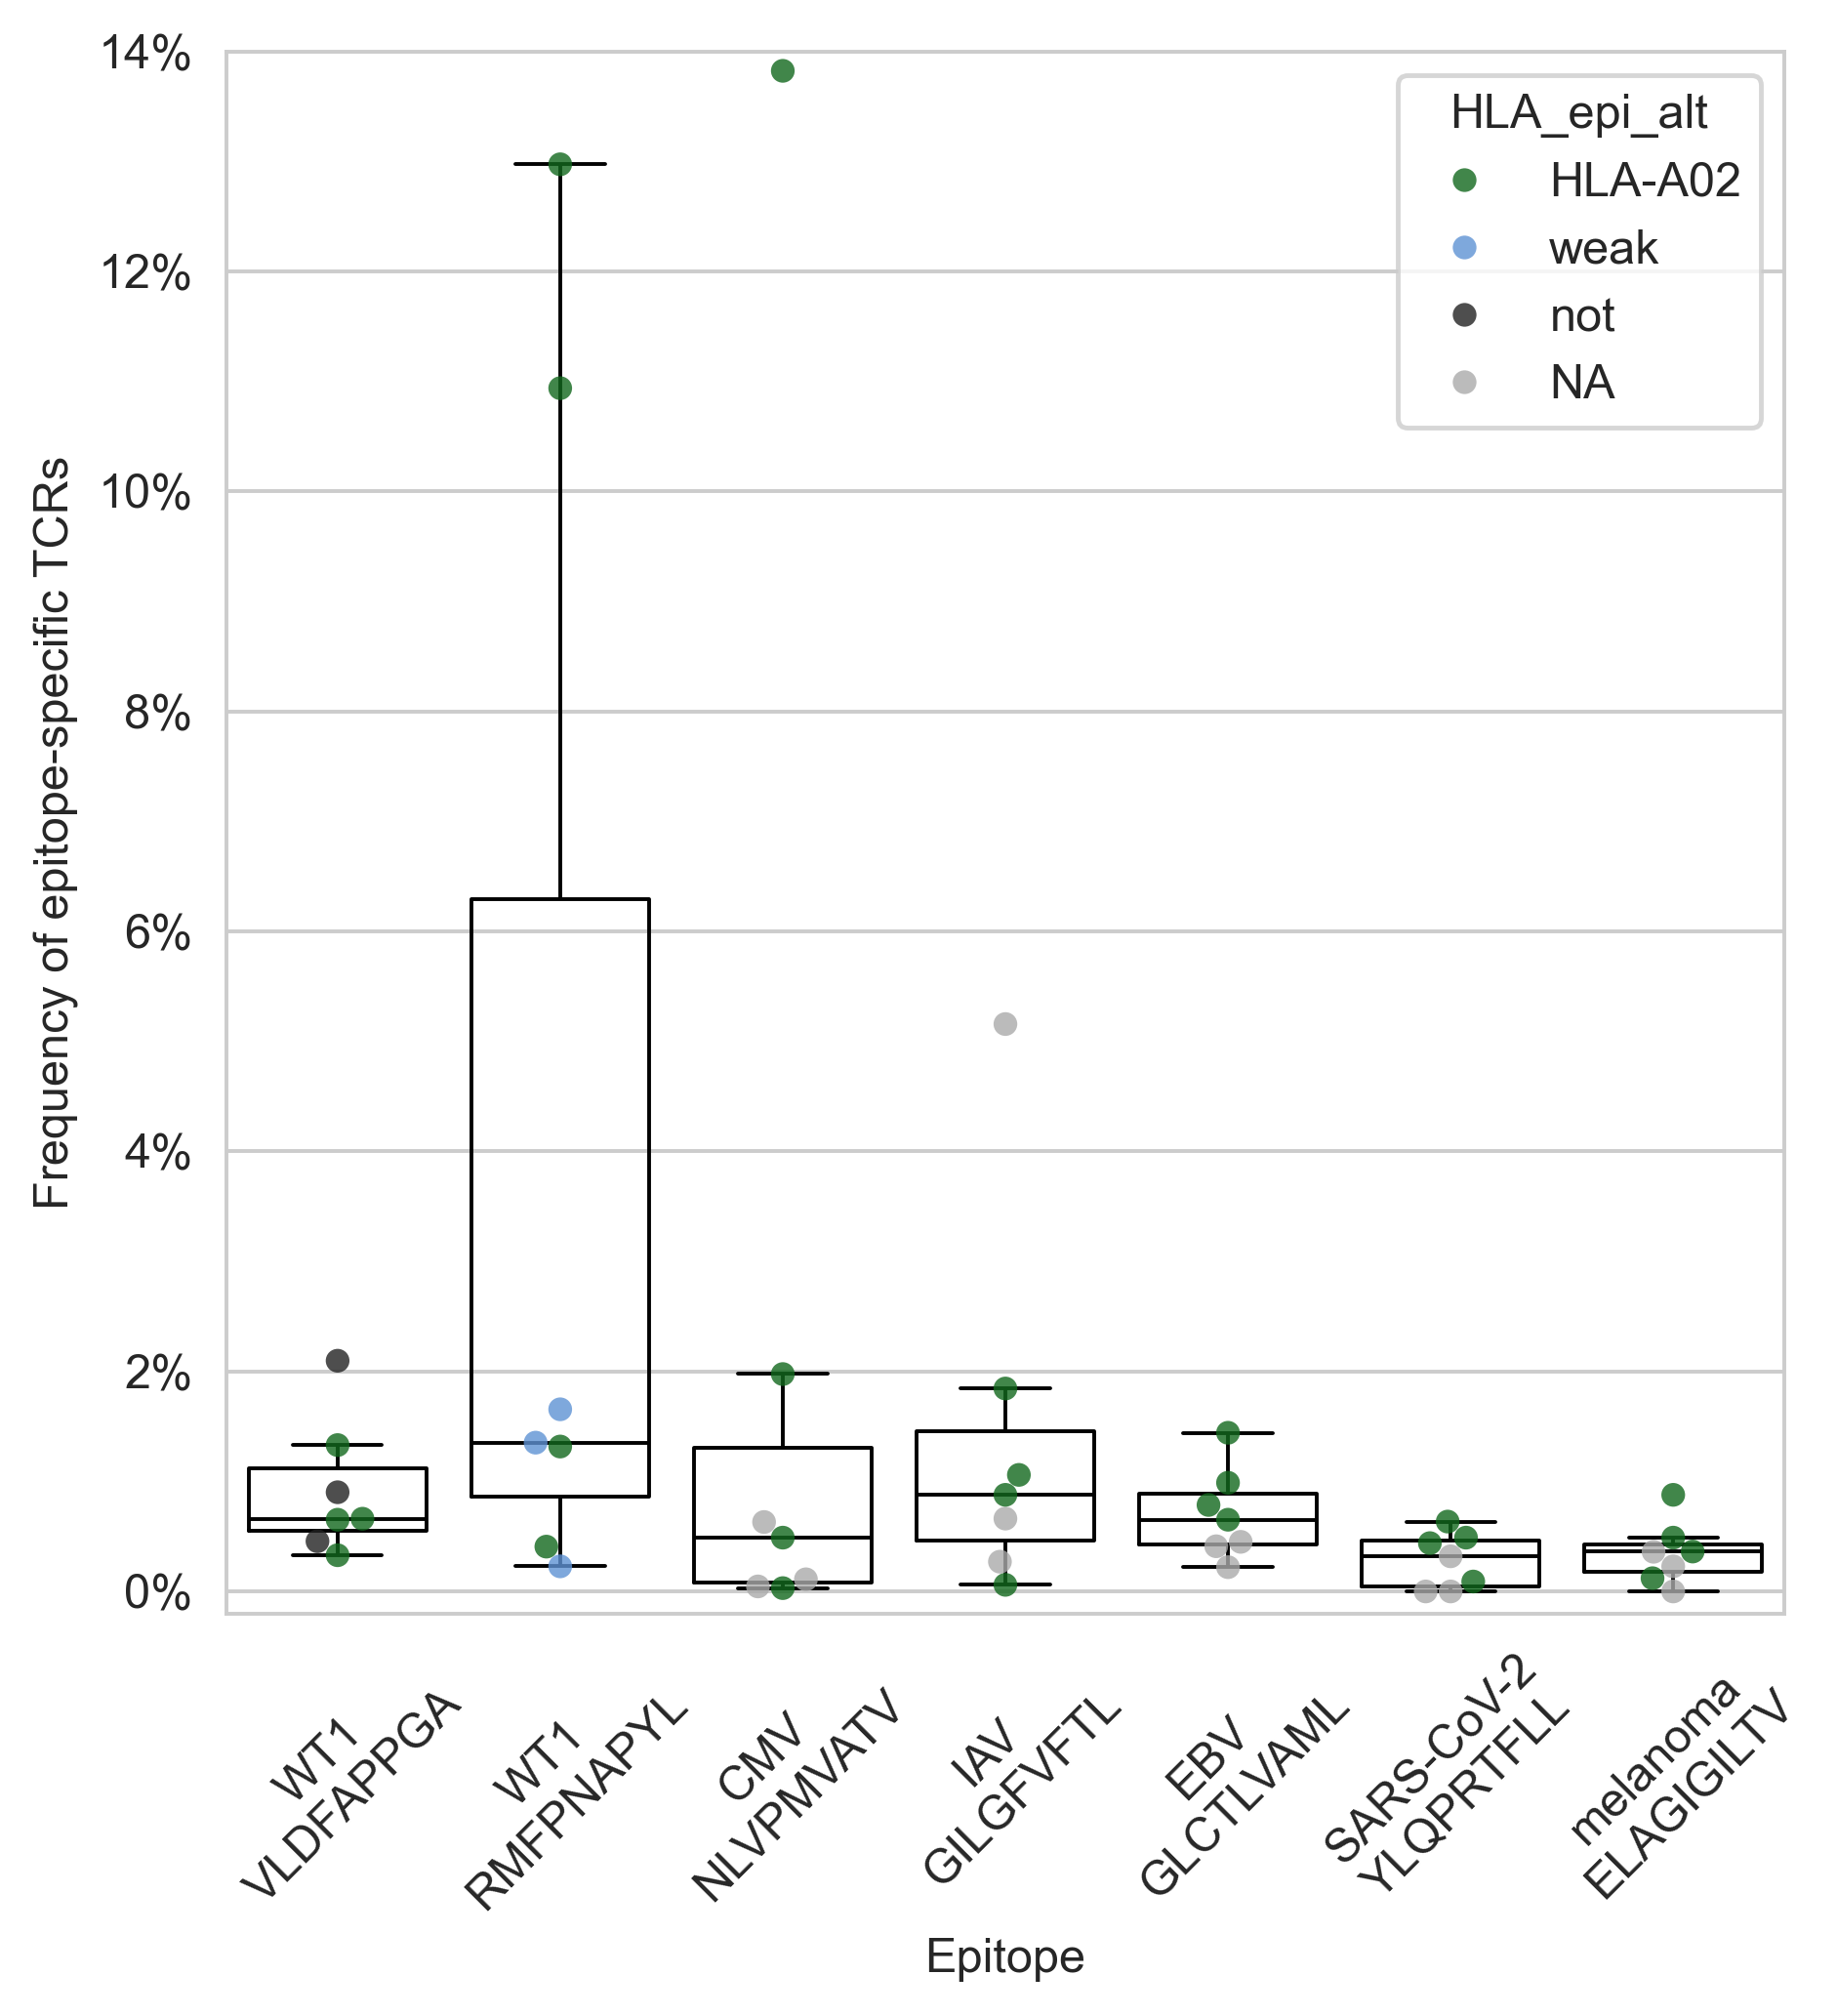

In [15]:
plot_scTCRfreq_hla(df_sc,"AML-BM-SC","HLA_epi_alt",["#12681D","#5E92D4","#222222","#AAAAAA"],["HLA-A02","weak","not","NA"])

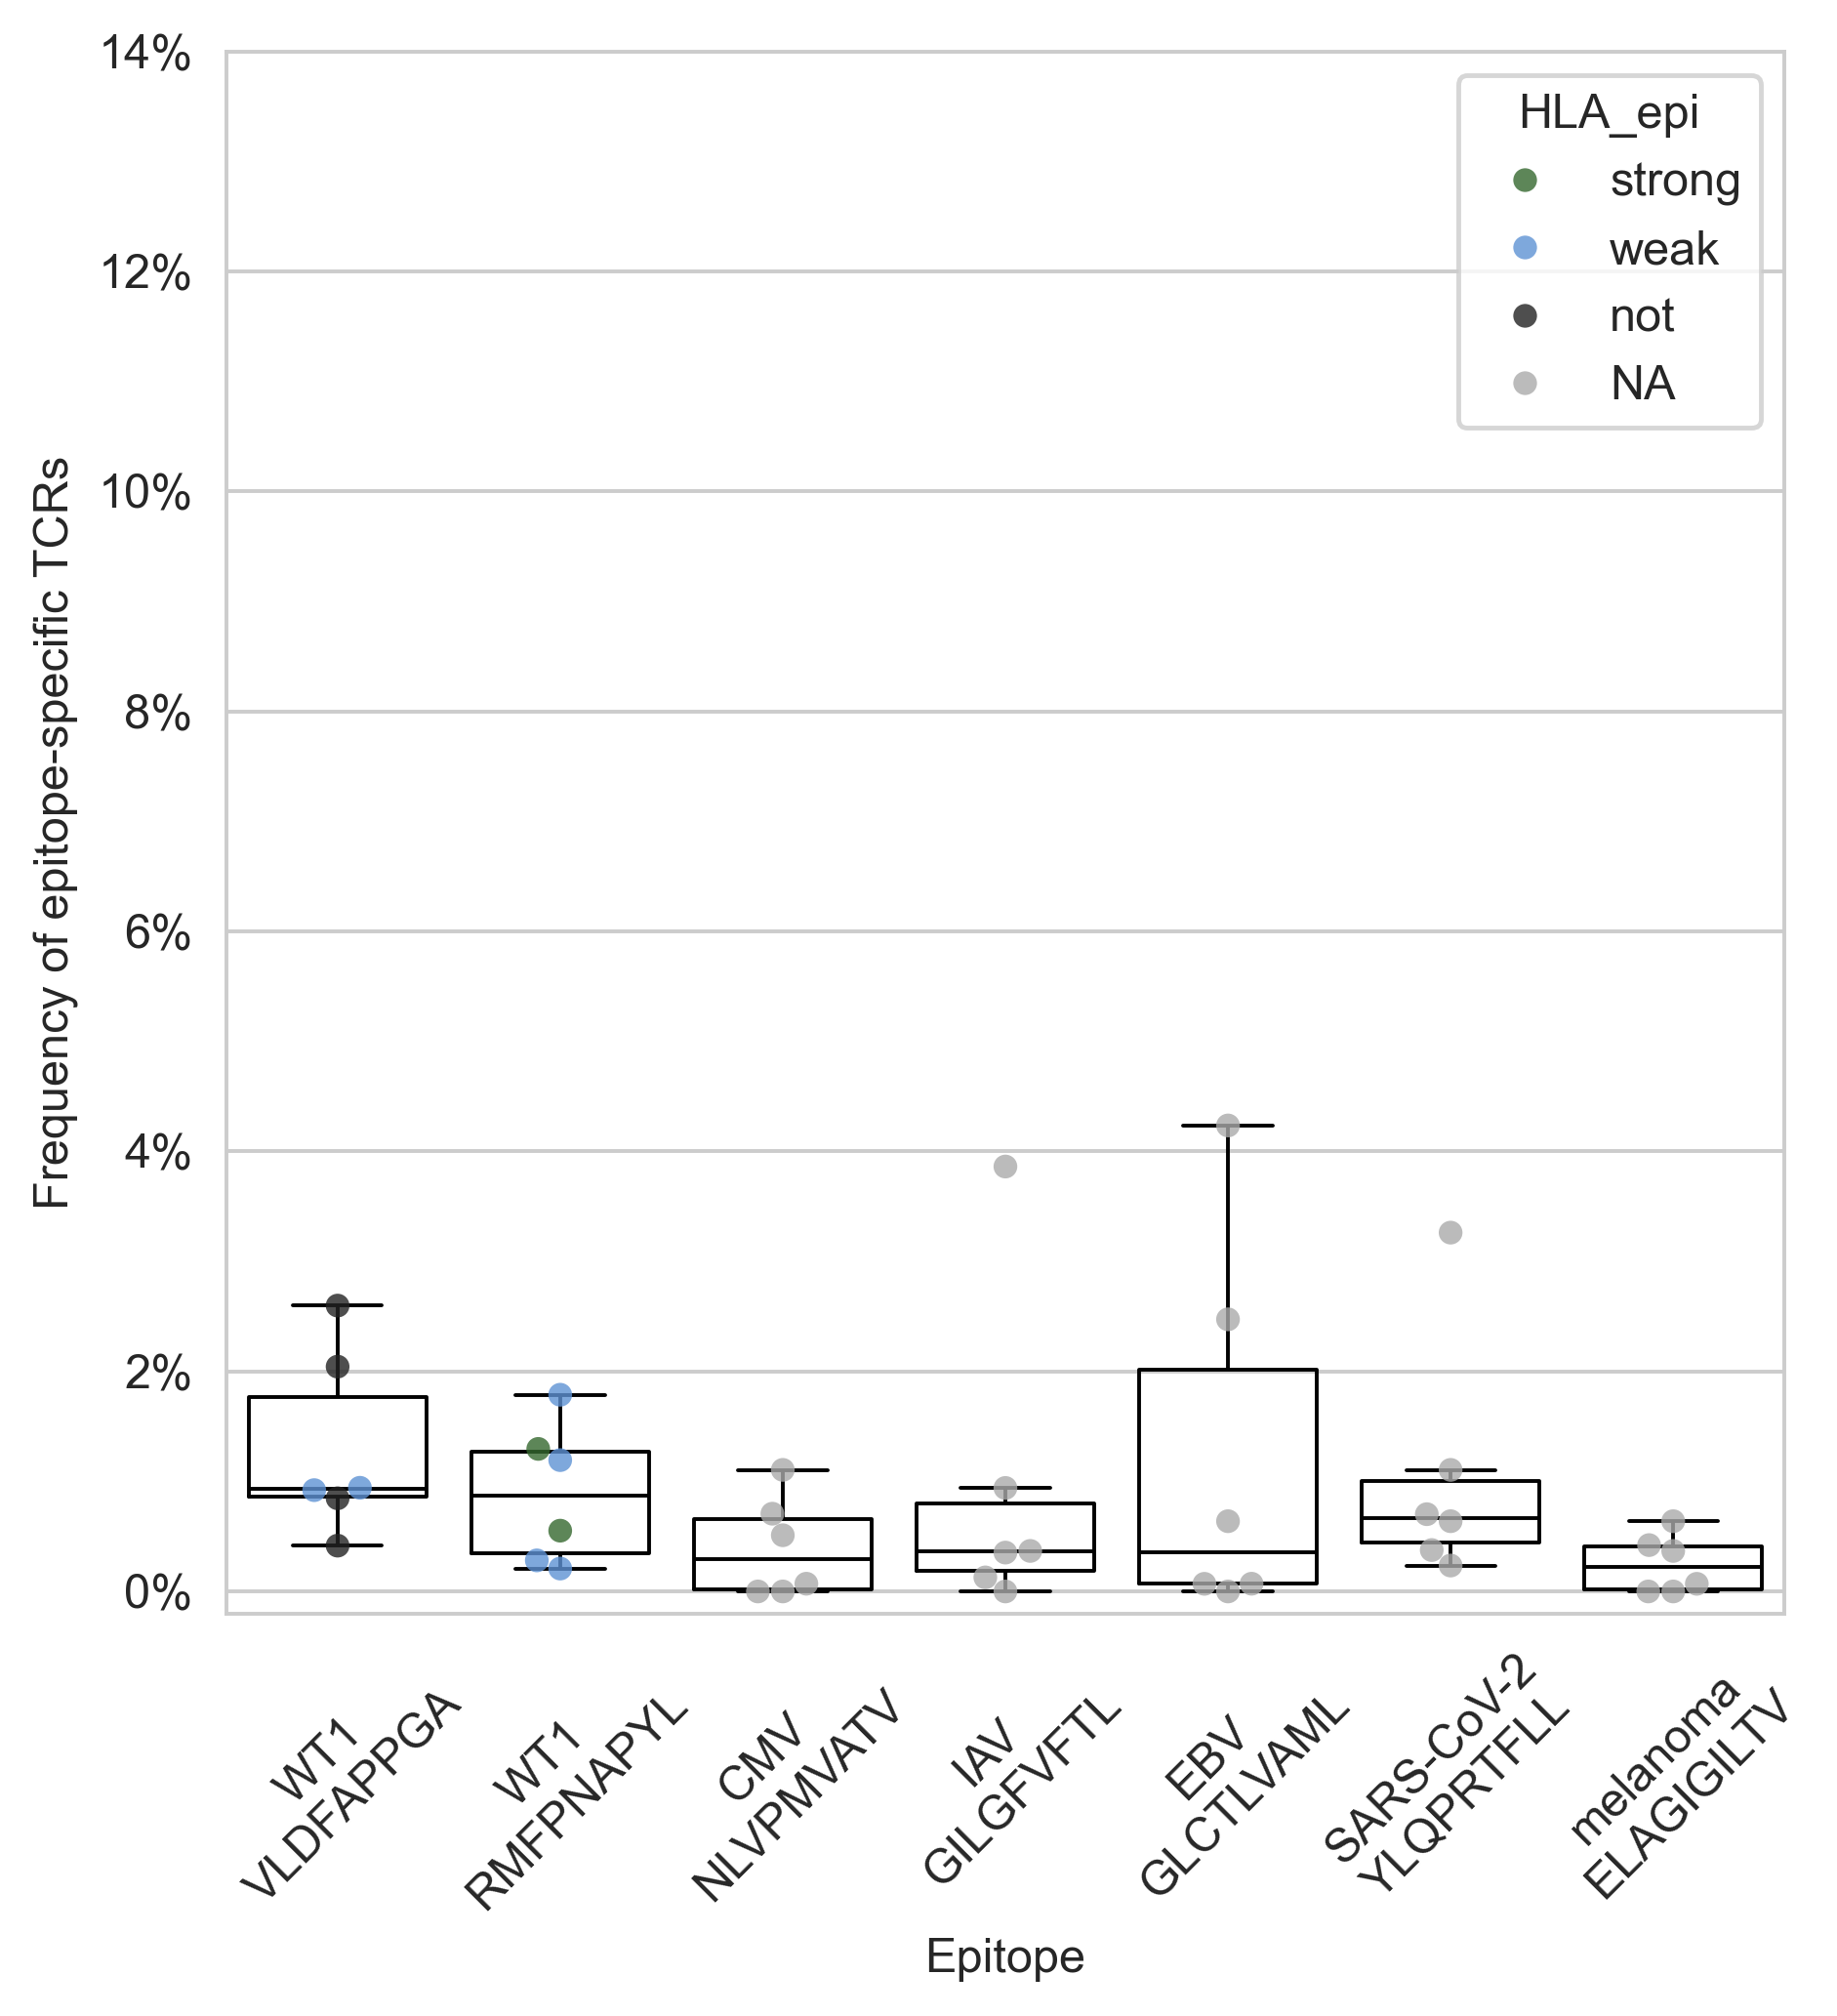

In [16]:
plot_scTCRfreq_hla(df_sc,"CML-PB-SC","HLA_epi",["#34682E","#5E92D4","#222222","#AAAAAA"],["strong","weak","not","NA"])

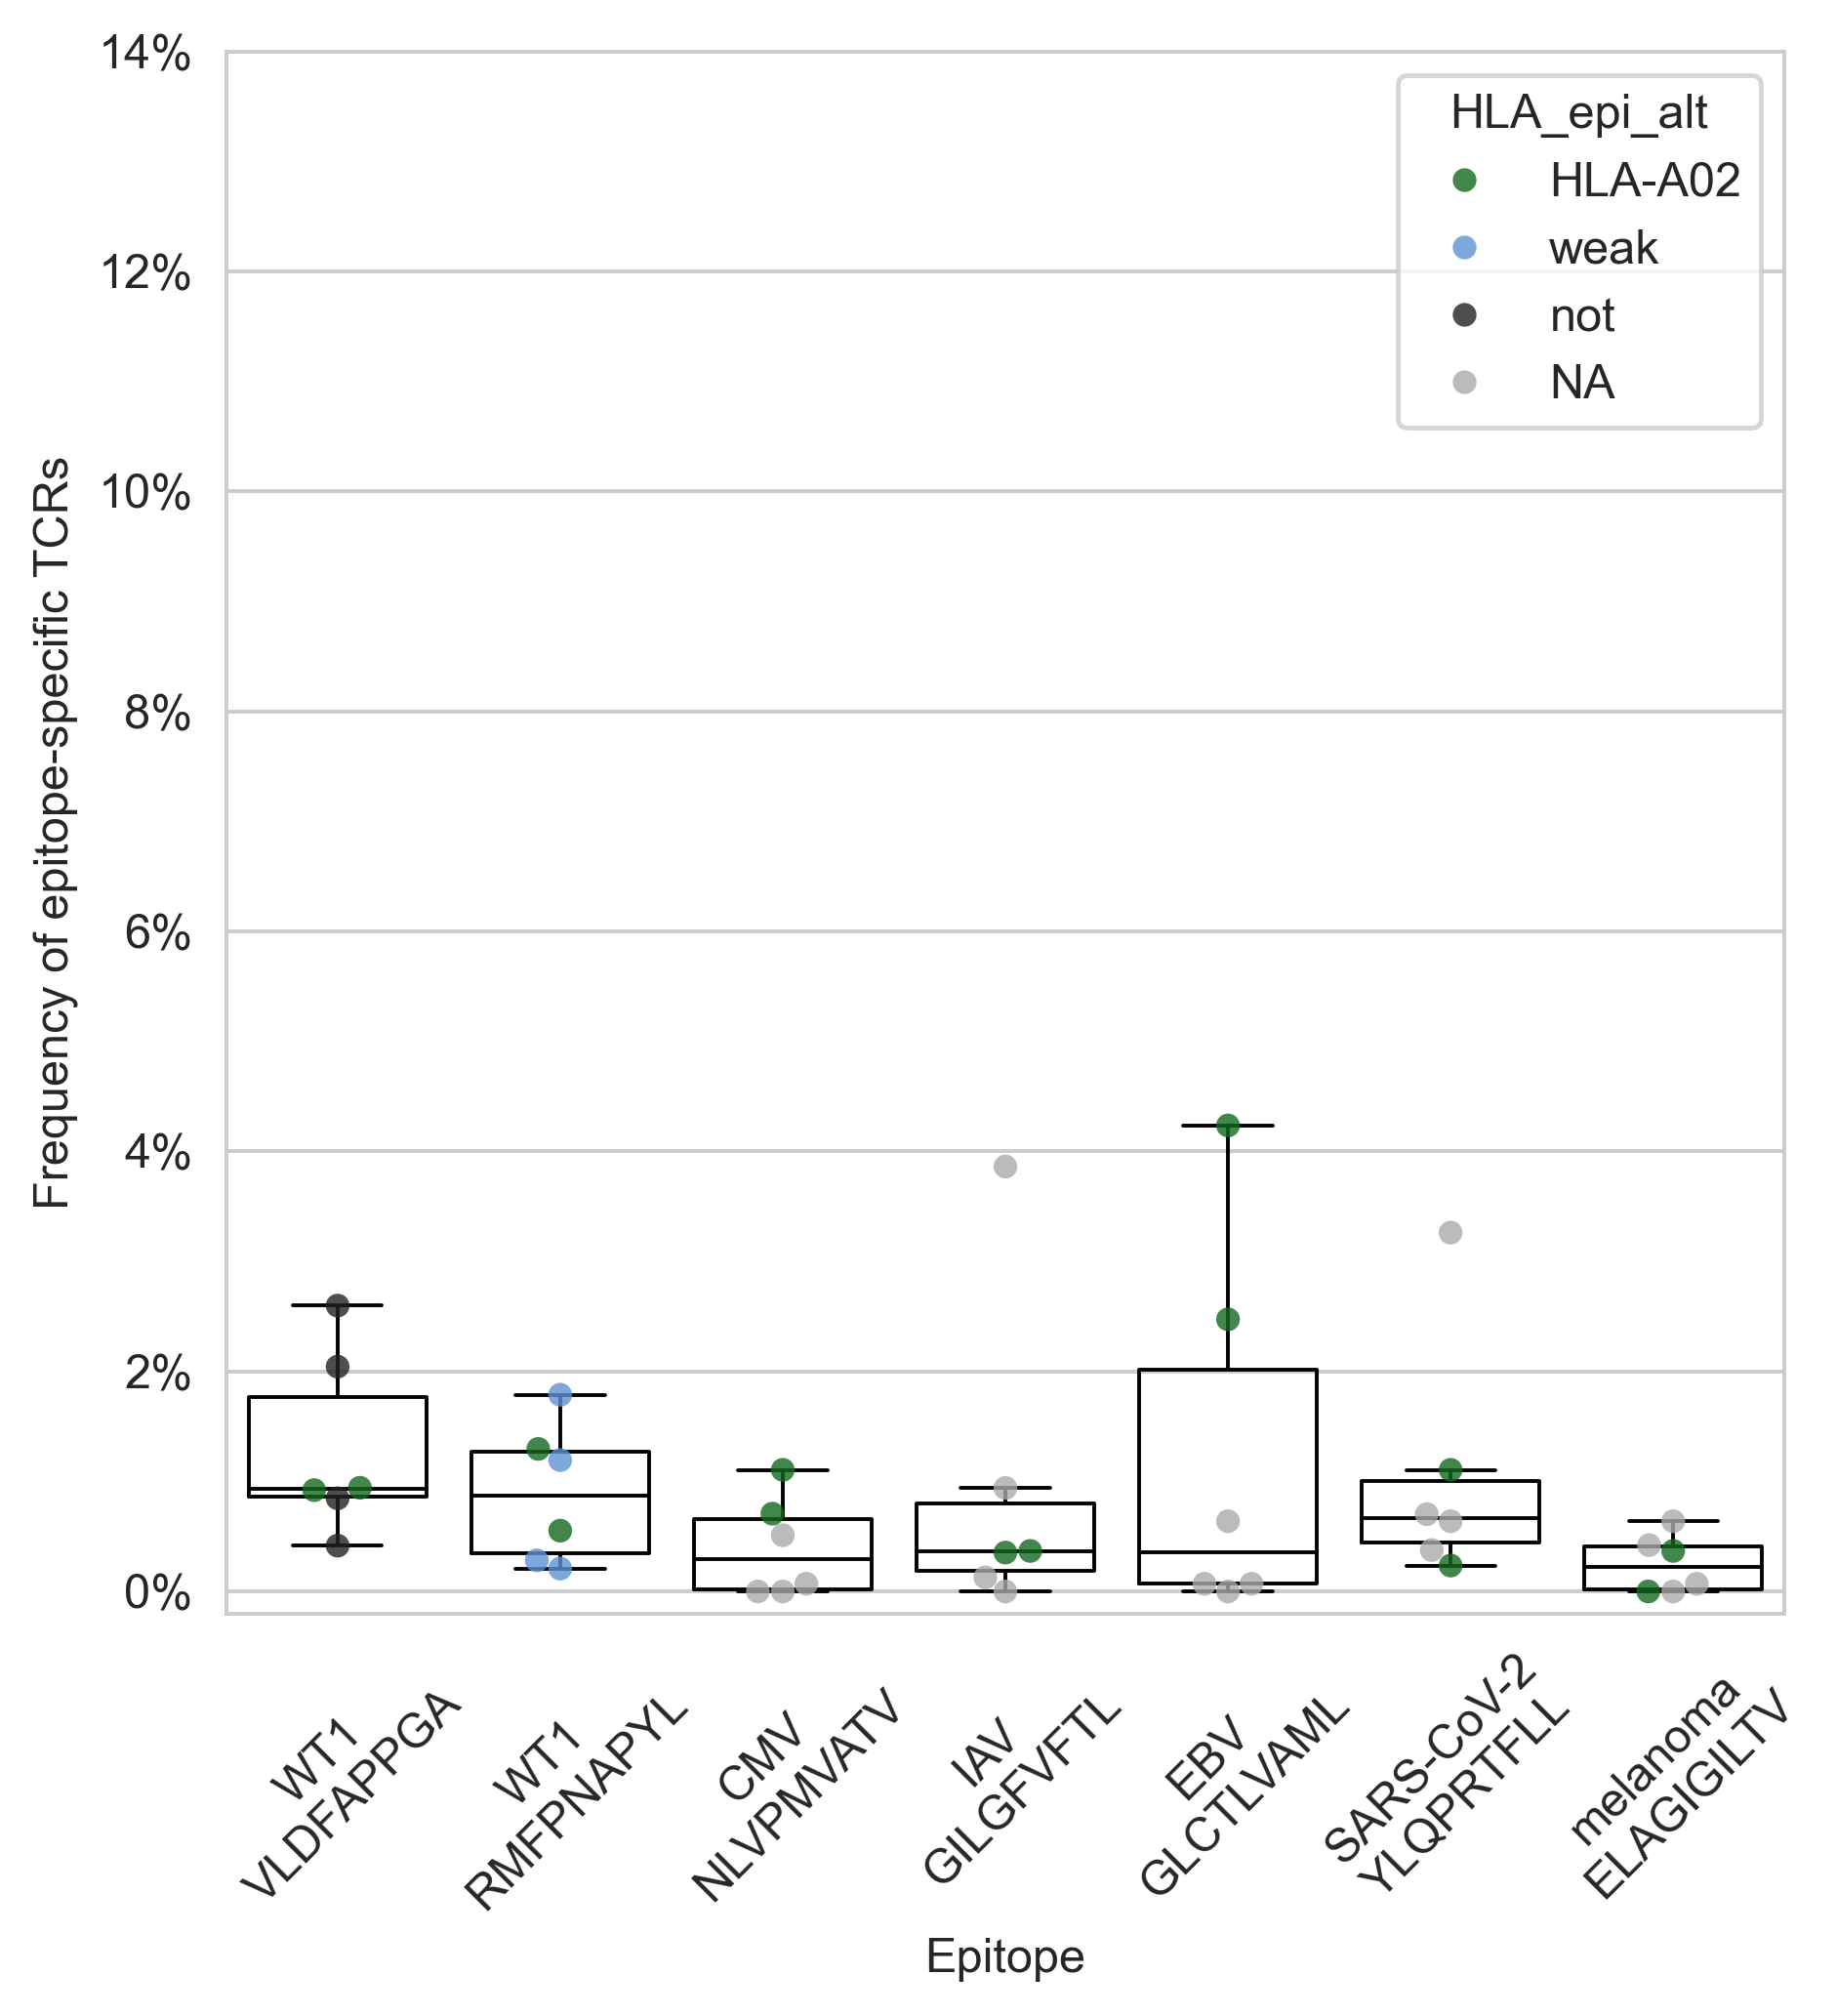

In [17]:
plot_scTCRfreq_hla(df_sc,"CML-PB-SC","HLA_epi_alt",["#12681D","#5E92D4","#222222","#AAAAAA"],["HLA-A02","weak","not","NA"])

## Frequencies of epitope-specific TCRs from each patient
clones are separated by vertical lines

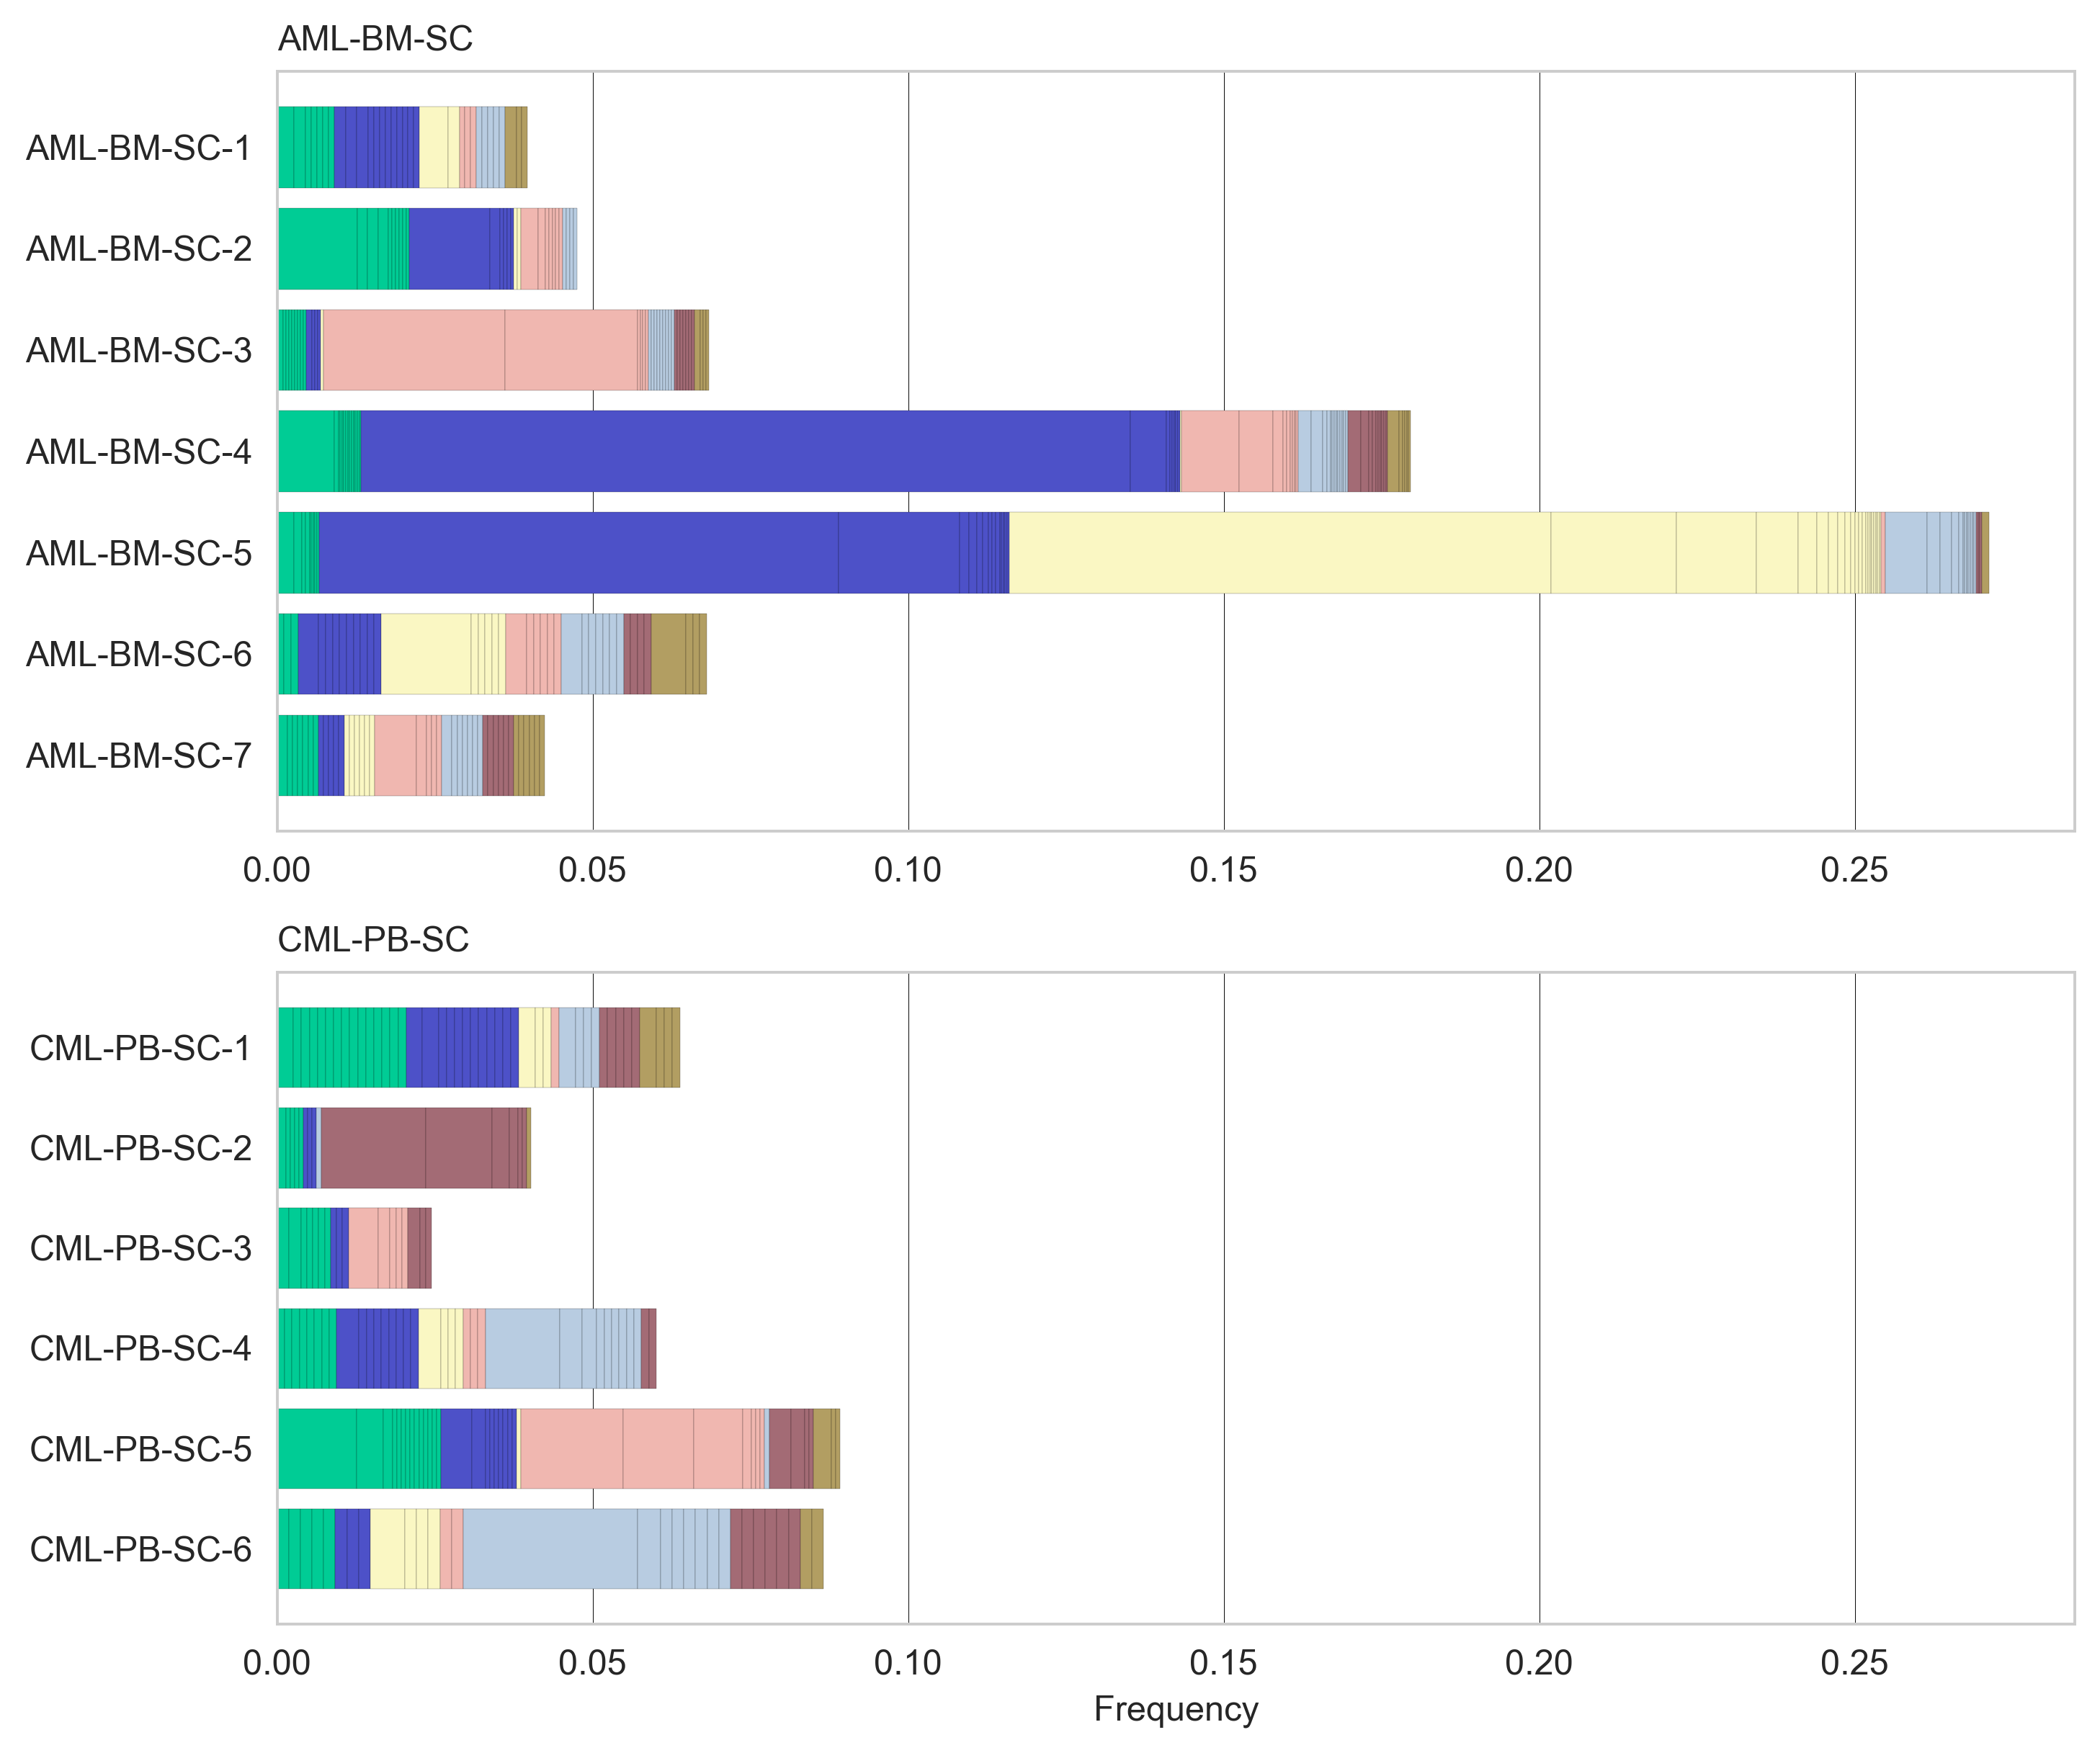

In [18]:
plot_freqbars_all(d_cohorts,cohorts=cohorts_sc,mods=epis,h=8,figpath="")

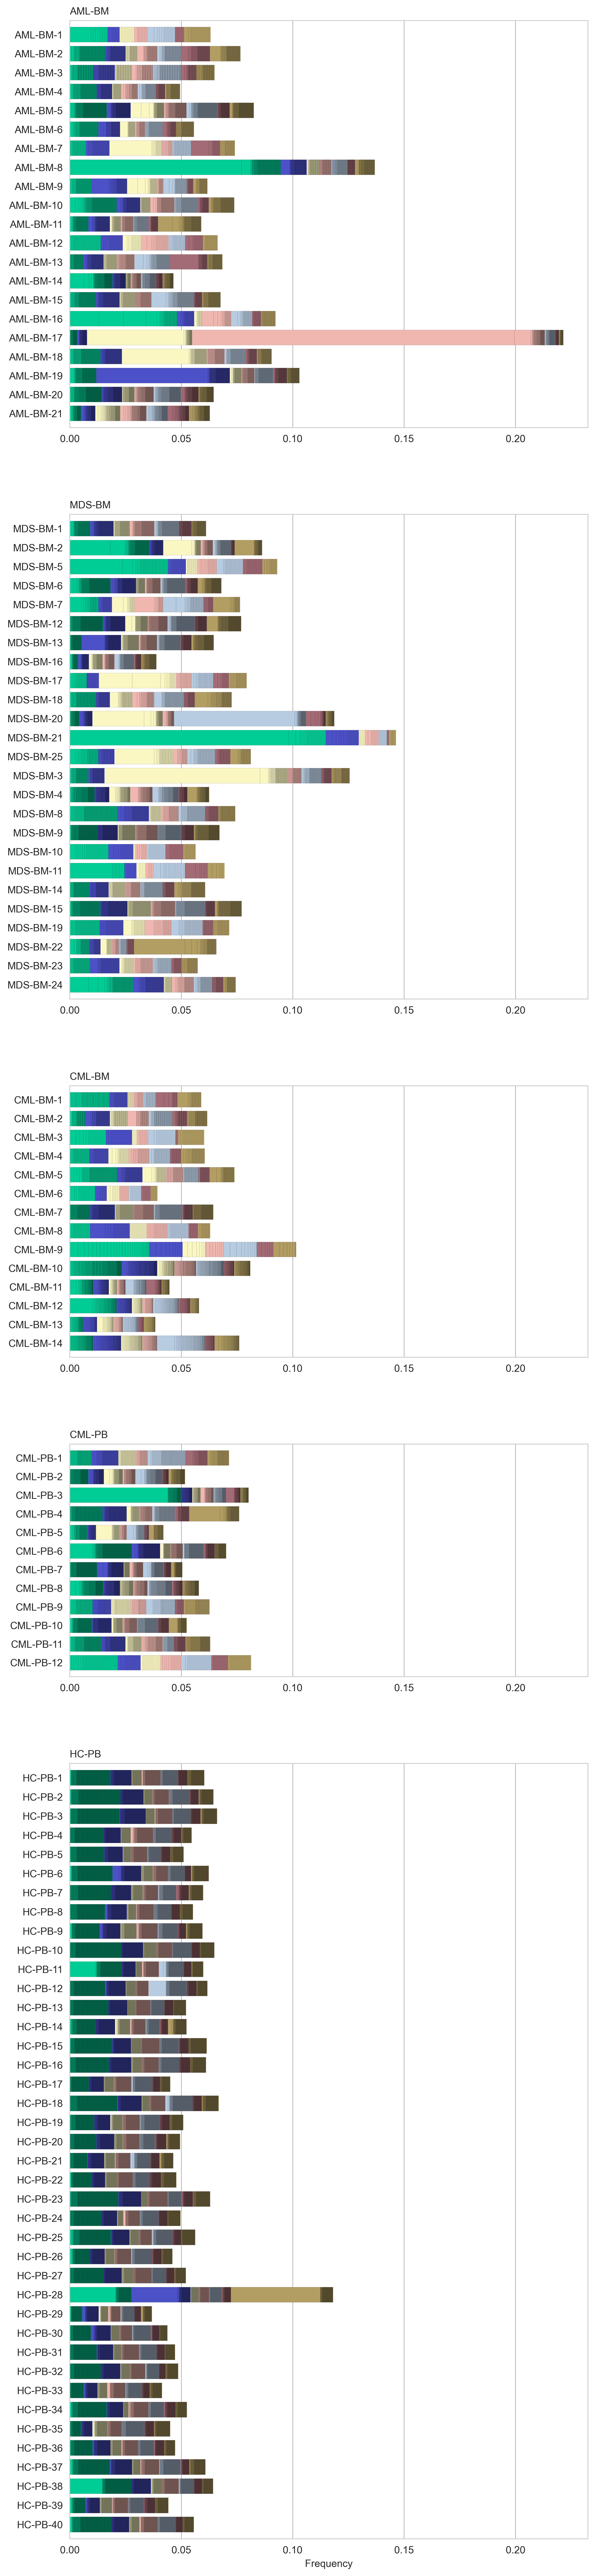

In [19]:
plot_freqbars_all(d_cohorts,cohorts=cohorts_bulk,mods=epis,h=45,figpath="")

# Clonality in bulk cohorts

$\textrm{Simpson clonality}=\sqrt{\sum_{i=1}^R P_i^2}$, where $R$ is the total number of rearrangments, and $P_i$ the productive frequency of rearrangament $i$.

In [20]:
df_bulk_clonality = pd.read_csv("data/bulk_clonality.csv")

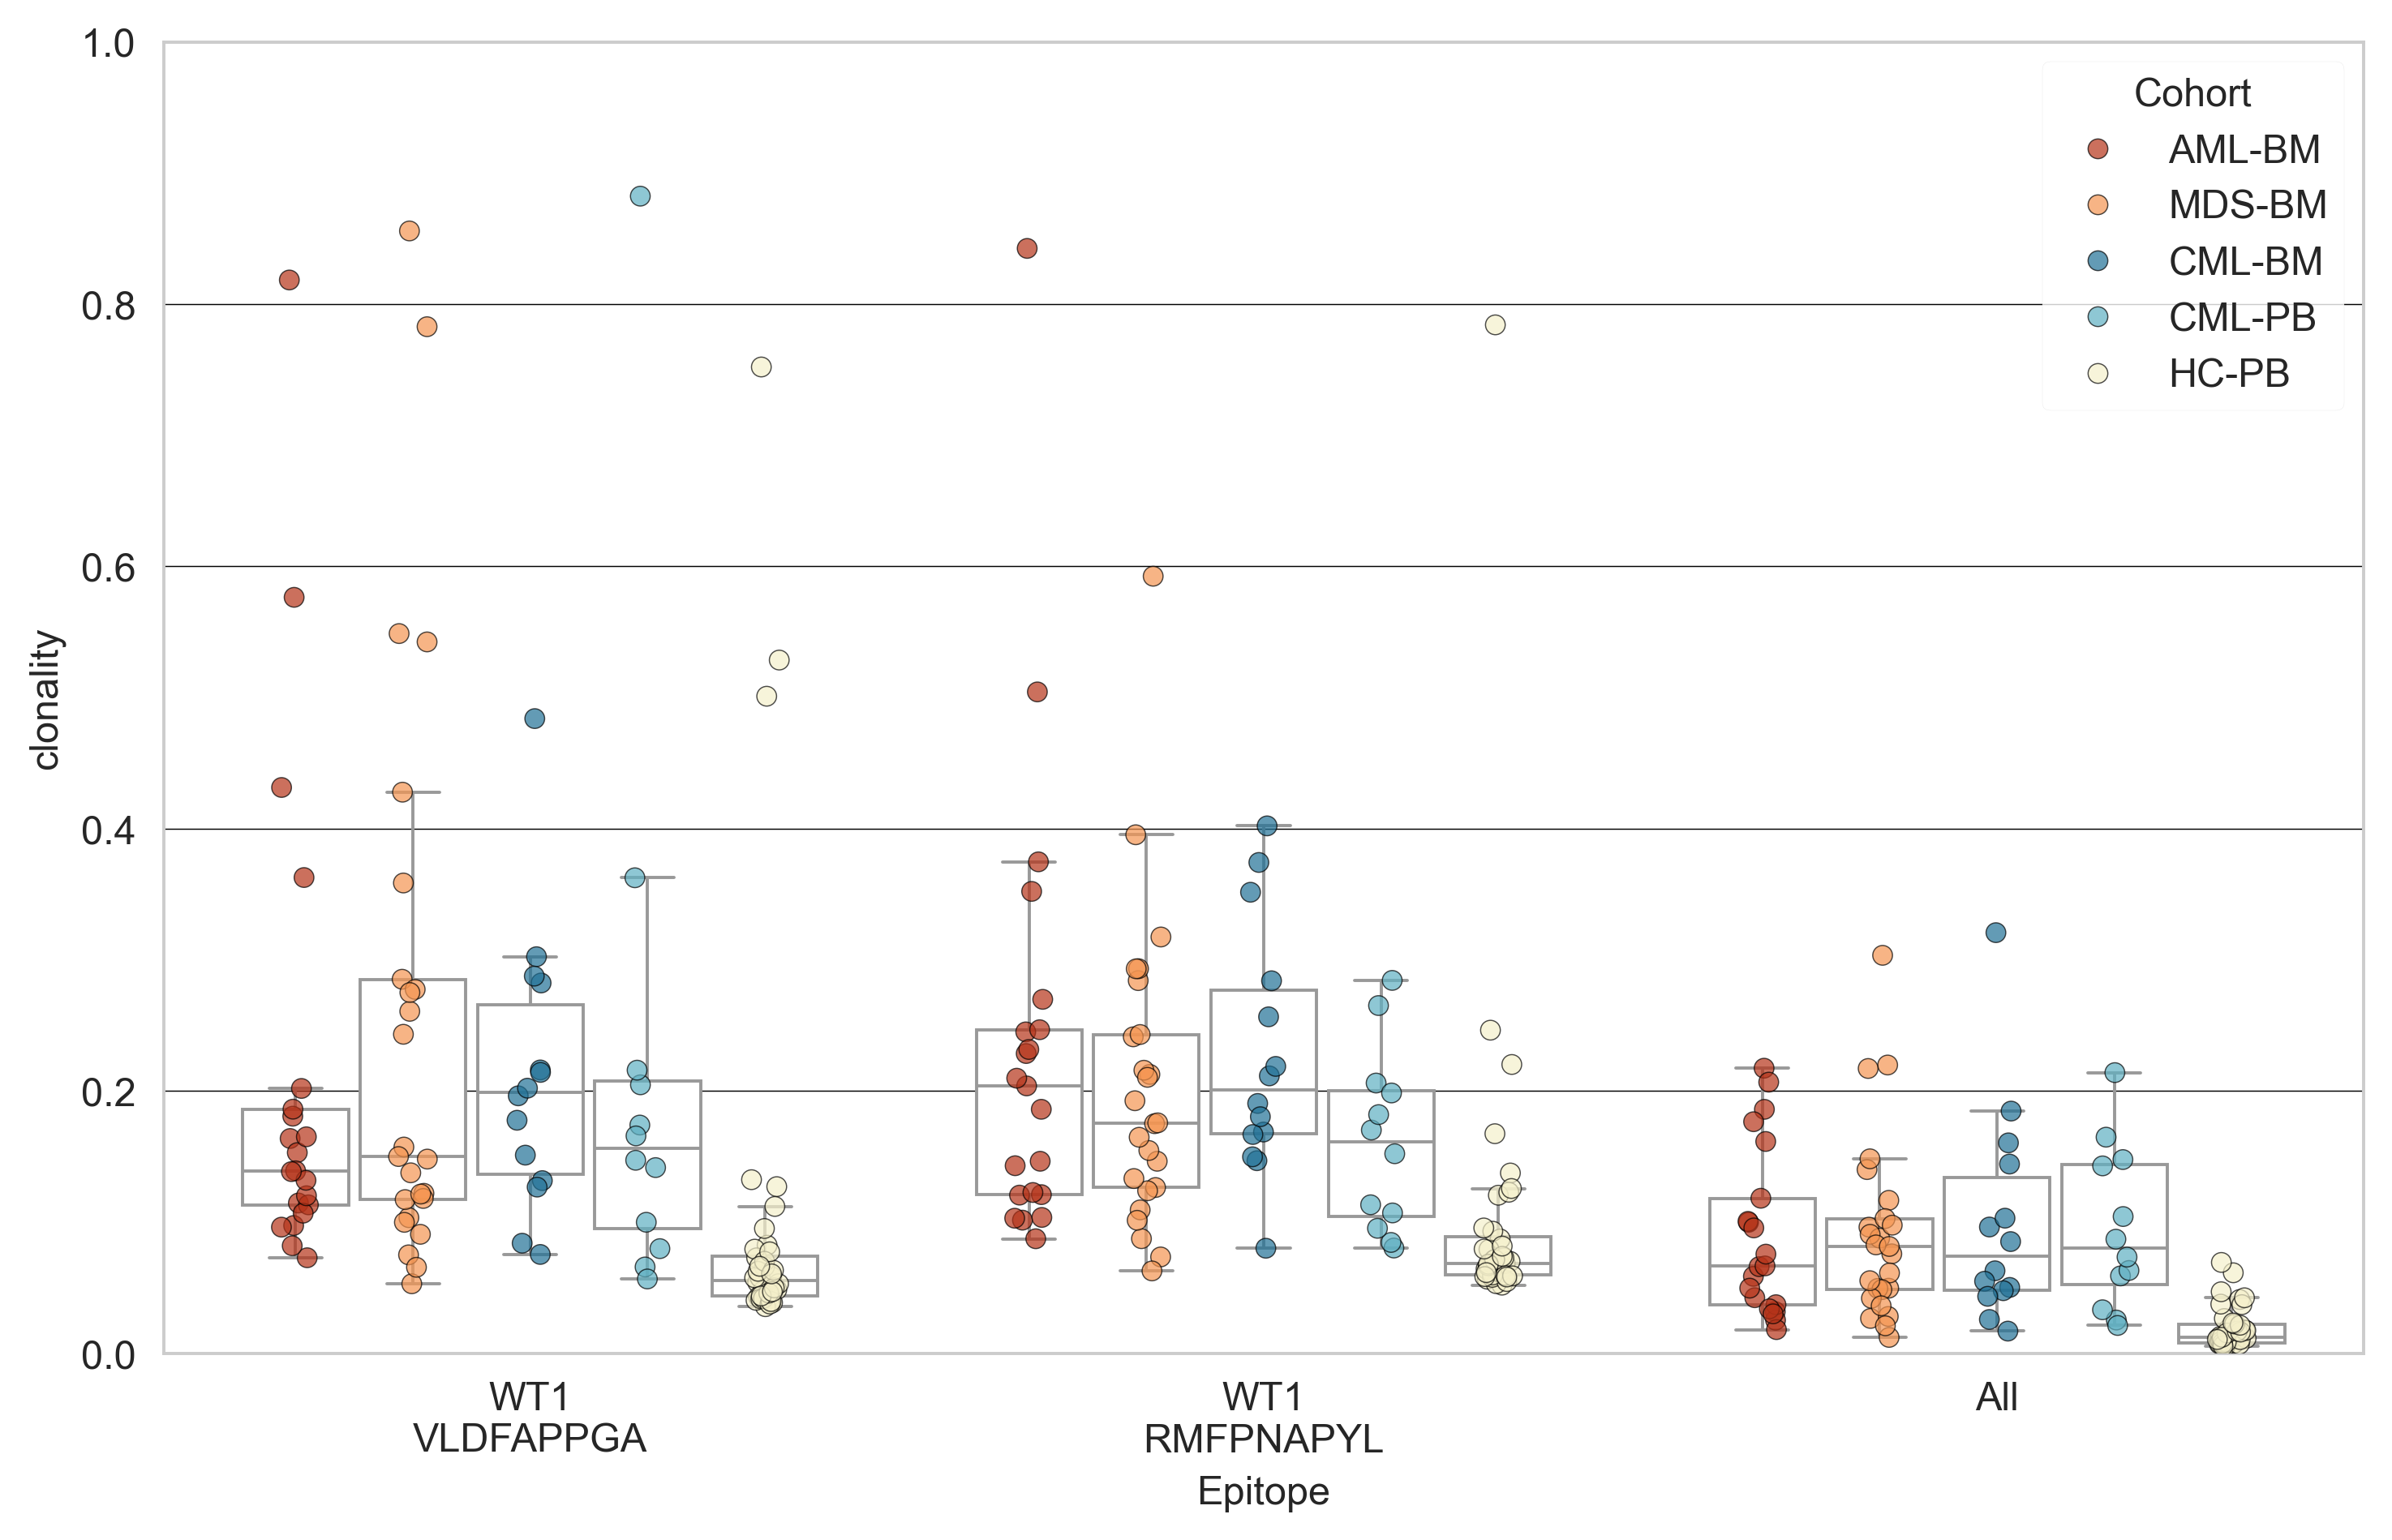

In [21]:
ho = ["AML-BM","MDS-BM","CML-BM","CML-PB","HC-PB"]
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10,6),dpi=350)
    sns.boxplot(df_bulk_clonality,x="Epitope",y="clonality",hue="Cohort",palette=["w"]*5,fliersize=0,gap=0.1,linewidth=0.8,
                hue_order=ho,order=["VLD","RMF","All"],legend=False)
    sns.stripplot(df_bulk_clonality,x="Epitope",y="clonality",hue="Cohort",dodge=True,size=5,palette=cohort_cols,legend=True,
                  hue_order=ho,order=["VLD","RMF","All"],alpha=0.7,edgecolor="k",linewidth=0.3) 

    plt.grid(axis="y",linewidth=0.3,color="#010101")
    plt.ylim(0,1)
    
    plt.gca().set_xticklabels(["WT1\nVLDFAPPGA","WT1\nRMFPNAPYL","All"])
    plt.show()

## Mann Whitney U-test for clonality

In [22]:
d_cmean, d_cmedian = {}, {}
d_p, d_s = {}, {}
for epi in epis + ["All"]:
    d_cmean[epi], d_cmedian[epi] = {}, {}
    d_p[epi], d_s[epi] = {}, {}
    for c in cohorts_bulk:
        clos = df_bulk_clonality["clonality"][np.logical_and(df_bulk_clonality["Epitope"]==epi[:3],
                                                             df_bulk_clonality["Cohort"]==c)].values
        d_cmean[epi][c] = np.mean(clos)
        d_cmedian[epi][c] = np.median(clos)
        
        if c != "HC-PB": 
            clos_h = df_bulk_clonality["clonality"][np.logical_and(df_bulk_clonality["Epitope"]==epi[:3],
                                                             df_bulk_clonality["Cohort"]=="HC-PB")].values
            mwut = mannwhitneyu(clos,clos_h,alternative="greater")
            d_p[epi][c]= mwut.pvalue 
            d_s[epi][c]= mwut.statistic  
            
df_mean_clonality = pd.DataFrame(d_cmean)
df_median_clonality = pd.DataFrame(d_cmedian)
df_pval_greater = pd.DataFrame(d_p)
df_stat_greater = pd.DataFrame(d_s)

In [23]:
df_mean_clonality

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
AML-BM   0.211909   0.235330   0.321724   0.236359   0.176738   0.282740   
MDS-BM   0.256577   0.204934   0.385050   0.248039   0.222172   0.184544   
CML-BM   0.209275   0.227174   0.289015   0.249872   0.232850   0.246731   
CML-PB   0.216239   0.161439   0.245570   0.182403   0.183609   0.172078   
HC-PB    0.099978   0.101797   0.091151   0.080128   0.085032   0.075403   

        ELAGIGILTV       All  
AML-BM    0.181572  0.090233  
MDS-BM    0.315891  0.091494  
CML-BM    0.274997  0.099625  
CML-PB    0.274073  0.094531  
HC-PB     0.122063  0.018621

In [24]:
df_median_clonality

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
AML-BM   0.139008   0.203763   0.185744   0.193020   0.136790   0.193937   
MDS-BM   0.149895   0.175578   0.360078   0.215010   0.201452   0.167774   
CML-BM   0.199117   0.200900   0.296776   0.233094   0.204485   0.208133   
CML-PB   0.156345   0.161063   0.166188   0.180193   0.135544   0.143588   
HC-PB    0.055654   0.068237   0.085607   0.071576   0.066219   0.068388   

        ELAGIGILTV       All  
AML-BM    0.151521  0.066494  
MDS-BM    0.237153  0.081325  
CML-BM    0.244073  0.073907  
CML-PB    0.219475  0.080048  
HC-PB     0.090763  0.011830

In [25]:
df_pval_greater

VLDFAPPGA     RMFPNAPYL     NLVPMVATV     GILGFVFTL     GLCTLVAML  \
AML-BM  2.070751e-07  1.629016e-07  1.277329e-09  4.584929e-09  5.177360e-08   
MDS-BM  1.550713e-07  1.919980e-07  2.278781e-08  2.528086e-09  8.092905e-08   
CML-BM  5.131280e-06  1.672366e-06  3.114410e-07  1.224037e-07  1.519492e-06   
CML-PB  1.065226e-04  8.222132e-05  3.886459e-07  1.157401e-06  8.120586e-06   

           YLQPRTFLL    ELAGIGILTV           All  
AML-BM  1.537318e-09  2.730692e-06  2.039928e-08  
MDS-BM  7.722892e-09  3.084625e-08  2.741157e-09  
CML-BM  3.360137e-08  2.949220e-06  6.304673e-07  
CML-PB  2.179506e-06  1.088158e-05  2.681668e-06

In [26]:
df_stat_greater

VLDFAPPGA  RMFPNAPYL  NLVPMVATV  GILGFVFTL  GLCTLVAML  YLQPRTFLL  \
AML-BM      754.0      757.0      813.0      799.0      771.0      811.0   
MDS-BM      880.0      877.0      906.0      934.0      889.0      920.0   
CML-BM      504.0      516.0      533.0      542.0      517.0      554.0   
CML-PB      411.0      414.0      468.0      458.0      439.0      452.0   

        ELAGIGILTV    All  
AML-BM       720.0  782.0  
MDS-BM       902.0  933.0  
CML-BM       510.0  526.0  
CML-PB       436.0  450.0

### FDR correction to VLD and RMF clonalities 

In [27]:
ps = list(df_pval_greater["VLDFAPPGA"].values)+list(df_pval_greater["RMFPNAPYL"].values)
tmp = false_discovery_control(ps)
print(tmp)

[4.14150121e-07 4.14150121e-07 6.84170714e-06 1.06522624e-04
 4.14150121e-07 4.14150121e-07 2.67578525e-06 9.39672205e-05]


# CDR3$\beta$ lengths in bulk cohorts

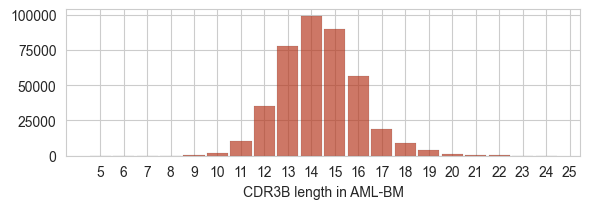

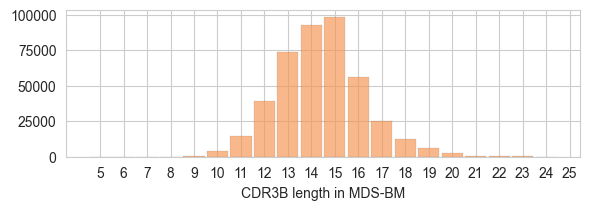

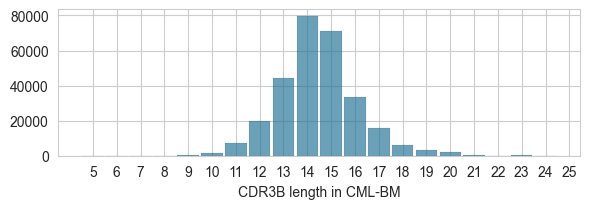

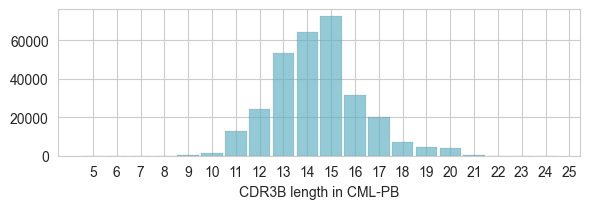

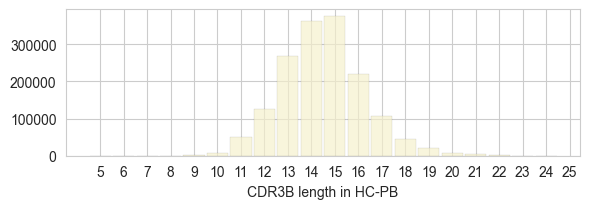

In [28]:
for co in cohorts_bulk:
    with open("data/CDR3_lists/"+co+"_all-CDR3B.txt","r") as f:
         cdr3s = f.read().split(',')
    lens = [len(c) for c in cdr3s]
    with sns.axes_style("whitegrid",{'patch.force_edgecolor': True,'patch.edgecolor': '#000000'}):
        plt.figure(figsize=(6,2.2))
        ind = np.where(np.array(cohorts_bulk)==co)[0][0]
        plt.hist(lens,range=(5,30),bins=np.arange(4.5,25.5),align="mid",rwidth=0.9,color=cohort_cols[ind]+"AA")
        plt.xticks(np.arange(5,26))
        plt.xlabel("CDR3B length in "+co)
        plt.tight_layout()
        plt.show()